## 1. load packages

In [1]:
import os
import textwrap as tw
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mpc
import matplotlib.gridspec as gridspec
import seaborn as sn
import matplotlib
from matplotlib import rcParams 
from matplotlib.patches import Patch
from matplotlib.transforms import ScaledTranslation

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

from qiime2 import Artifact


## upset_plot function is from https://github.com/jwdebelius/eurydice
from upset_plot import (build_upset_matrix,
                        plot_upset_part_only
                        )

In [2]:
%matplotlib inline

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [3]:
### set up data path

data_dir = '../../../data'
strain_ana = '../../../strain_ana/all'
fig_dir = '../../../figure/primary'
out_dir = '../../../output/primary'



final_fig_dir = '../../../figure/final'

strain_raw_dir = '../../../data/strainplan'
strain_out_dir = '../../../output/all_strain'

## 2. load and clean data

### 2.1 load and clean metadata

In [4]:
## load the metadata for the cross-sectional dataset:
## 68 parent fecal in 3rd trimester, 68 parent vaginal in 3rd trimester and 68 infant fecal at month 2-4
## This is the dataset we used for the cross-sectional analysis
included_cxsectional_manifest = pd.read_csv(f'{data_dir}/EC0556b_primary_analysis_manifest.tsv',
                                sep='\t',
                                index_col=0,
                                dtype=str)

## subset the cross-sectional metadata for parent and infant
included_cxsection_manifest_parent = included_cxsectional_manifest.loc[included_cxsectional_manifest['mwgs_part_type'] == '1'].copy()
included_cxsection_manifest_kid = included_cxsectional_manifest.loc[included_cxsectional_manifest['mwgs_part_type'] == '2'].copy()

In [5]:
## load the metadata for the longitudinal dataset
all_manifest = pd.read_csv(f'{data_dir}/all_samples_metadata.tsv',
                                sep='\t',
                                index_col=0,
                                dtype=str)

## subset all infant data
all_manifest_kid = all_manifest.loc[(all_manifest['mwgs_part_type'] == '2') & 
                                    (all_manifest['PregID'].isin(included_cxsection_manifest_kid['PregID']))].copy()

## keep longitudinal infant data only
longitudinal_kid = all_manifest_kid.loc[~all_manifest_kid.index.isin(included_cxsection_manifest_kid.index)].copy()

## combine cross-sectional parent data, cross-sectional infant data and longitudinal infant data
## This is the dataset we used 
included_manifest = pd.concat([included_cxsection_manifest_parent,
                               included_cxsection_manifest_kid,
                               longitudinal_kid])

In [6]:
## convert age to month
included_manifest['mwgs_age_month'] = np.floor(included_manifest['mwgs_age_yr'].astype('float64')*365/30)

## define age group
included_manifest['mwgs_age_month_g'] = pd.cut(included_manifest['mwgs_age_month'].astype(float),
                                                [0,1,4,7,11,float('inf')],
                                                include_lowest=True,
                                                labels=['0-1','2-4','5-7','8-11','maternal'])

In [7]:
## identify infants with repeated samples in 0-1, 2-4 and 5-7
included_manifest_kid = included_manifest[included_manifest['mwgs_part_type'] == '2'].copy()
included_manifest_kid['included'] = included_manifest_kid.groupby('PregID')['mwgs_age_month_g'].transform(
    lambda x: any(x=='0-1') and any(x=='2-4') and any(x=='5-7')

)
included_manifest_kid_long = included_manifest_kid[included_manifest_kid['included']]

## include pregnancies with repeated kids' fecal in 0-1, 2-4 and 5-7 and their parents' samples
## This is the dataset we used for the longitudinal modeling analysis
included_manifest_long = included_manifest[included_manifest['PregID'].isin(included_manifest_kid_long['PregID'])].copy()

### 2.2 load delivery mode, prenetal antibiotics use and breastfeeding for cross-sectional dataset

In [8]:
## load birth delivery mode and prenatal antibiotics use data
deliv_antib_data = pd.read_csv(f'{data_dir}/kid_longum_ana.tsv',
                                sep='\t',
                                index_col=0,
                                dtype=str)[['PregID','birth_delivm','med_antib_pn']].drop_duplicates()
deliv_antib_data.set_index('PregID', inplace=True)

In [9]:
## load breastfeeding data
## clean the breastfeeding data: '-9' for missing, '1' for exclusively breastfeeding, '0' for not exclusively breastfeeding

breastfeeding_data = pd.read_csv(f'{data_dir}/kid_longum_ana.tsv',
                                sep='\t',
                                index_col=0,
                                dtype=str)[['mwgs_breastfed', 'mwgs_infant_diet']]
breastfeeding_data['mwgs_breastfed_problem'] = \
    breastfeeding_data.apply(lambda x: (x['mwgs_breastfed'] == '1' and x['mwgs_infant_diet'] in ['2','5','-9']) or 
                                     (x['mwgs_breastfed'] == '2' and x['mwgs_infant_diet'] in ['1','3','6','-9']), axis=1)

breastfeeding_data['mwgs_breastfed'] = \
    breastfeeding_data.apply(lambda x: '-9' if x['mwgs_breastfed_problem'] else x['mwgs_breastfed'], axis=1)

def exclusive_breastfeeding(row):
    if row['mwgs_breastfed'] == '-9' or row['mwgs_breastfed_problem']:
        return '-9'
    elif (not row['mwgs_breastfed_problem']) and row['mwgs_infant_diet'] == "1":
        return '1'
    else:
        return '0'

breastfeeding_data['exclusive_breastfed'] = breastfeeding_data.apply(exclusive_breastfeeding, axis=1)

In [10]:
## create mapping tab for family
mapping_tab_cxsectional_raw = included_cxsectional_manifest[['PregID','mwgs_spec_type','mwgs_part_type']].reset_index().set_index('PregID')

In [11]:
## merge the mapping data with exclusive breastfeeding, delivery mode and prenatal antibiotics use data
mapping_tab_cxsectional_breastfed = pd.merge(mapping_tab_cxsectional_raw,
                                             breastfeeding_data[['exclusive_breastfed']],
                                             left_on='sample-id', right_index=True, how='left')

mapping_tab = mapping_tab_cxsectional_breastfed.join(
    deliv_antib_data,
    how='left')

mapping_tab.reset_index(inplace=True)
mapping_tab.set_index('sample-id', inplace=True)

In [12]:
## get mapping tab for the family: PregID as index, exclusively breastfeeding for month 2-4
mapping_tab_fam = mapping_tab[mapping_tab['mwgs_part_type'] == '2'][
    ['PregID', 'birth_delivm', 'med_antib_pn', 'exclusive_breastfed']
].set_index('PregID')

### 2.3 load and clean feature table

In [13]:
## load SGB data with B.longum breakdown to B.longum longum, B.longum infantis and B.longum unclassified
mtp_species_blongum_breakdown_q2 = Artifact.load(f'{data_dir}/feature_table/mtp_species_blongum_breakdown_rel_ft.qza')
mtp_species_blongum_breakdown = \
    mtp_species_blongum_breakdown_q2.view(pd.DataFrame)

## load SGB data
mtp_species_q2 = Artifact.load(f'{data_dir}/feature_table/mtp_species_rel_ft.qza')
mtp_species = \
    mtp_species_q2.view(pd.DataFrame)

In [14]:
## subset the feature data for all included participants
mtp_species_included = mtp_species_blongum_breakdown.loc[included_manifest.index].copy()

## subset the feature data for parent fecal
mtp_species_parent_fecal = mtp_species_included.loc[
    included_manifest.loc[
        (included_manifest['mwgs_part_type'] == '1') & 
        (included_manifest['mwgs_spec_type'] == '1')
    ].index
].copy()

## subset the feature data for parent vaginal
mtp_species_parent_vaginal = mtp_species_included.loc[
    included_manifest.loc[
        (included_manifest['mwgs_part_type'] == '1') & 
        (included_manifest['mwgs_spec_type'] == '7')
    ].index
].copy()

## subset the feature data for infant fecal
mtp_species_child_fecal = mtp_species_included.loc[
    included_manifest.loc[
        (included_manifest['mwgs_part_type'] == '2') & 
        (included_manifest['mwgs_spec_type'] == '1')
    ].index
].copy()

### 2.4 load sequencing processing metadata

In [15]:
## read all sequencing processing data
process_metadata = pd.read_csv(f'{data_dir}/processing_included.tsv',
                               sep='\t',
                               index_col=0)

In [16]:
## filter processing data for subset groups

process_metadata_included = process_metadata.loc[included_manifest.index].copy()
process_parent_fecal = process_metadata.loc[mtp_species_parent_fecal.index].copy()
process_parent_vaginal = process_metadata.loc[mtp_species_parent_vaginal.index].copy()
process_child_fecal = process_metadata.loc[mtp_species_child_fecal.index].copy()

### 2.5 read strain transmission data

In [17]:
## available strains for analysis
strain_avail_analysis = pd.read_csv(f'{strain_ana}/primary_strain_avail_metadata.tsv',
                                    sep='\t',
                                    index_col=0)

In [18]:
strain_avail_analysis.loc['t__subsp.longum','species'] = "s__Bifidobacterium_longum_subsp.longum"
strain_avail_analysis.loc['t__subsp.infantis','species'] = "s__Bifidobacterium_longum_subsp.infantis"

In [19]:
## strain transmission info
strain_transmission_info = pd.read_csv(f'{strain_ana}/strain_transmission.tsv',
                                    sep='\t',
                                    index_col=0)

In [20]:
strain_transmission_info.loc['t__subsp.longum','species'] = "s__Bifidobacterium_longum_subsp.longum"
strain_transmission_info.loc['t__subsp.infantis','species'] = "s__Bifidobacterium_longum_subsp.infantis"

In [21]:
## unique # of infants with strain-level profile
strain_transmission_info['n_unique_kid_fecal'] = \
    strain_transmission_info['included_sample'].map(
        lambda x: len(included_manifest.loc[(included_manifest.index.isin(eval(x))) &
                      (included_manifest['mwgs_spec_type'] == '1') &
                      (included_manifest['mwgs_part_type'] == '2')]['PregID'].unique()))

In [22]:
## strain transmission records
strain_transmission_records = pd.read_csv(f'{strain_ana}/strain_transmission_record.tsv',
                                    sep='\t')

In [23]:
## microbes only detected in maternal or only detected in infant samples
exclusively_exist_strain = pd.read_csv(f'{strain_out_dir}/exclusively_exist_strain.tsv',
                                    sep='\t',
                                    index_col=0)

In [24]:
## unique # of infants with strain-level profile
exclusively_exist_strain['n_unique_kid_fecal'] = \
    exclusively_exist_strain['included_sample'].map(
        lambda x: len(included_manifest.loc[(included_manifest.index.isin(eval(x))) &
                      (included_manifest['mwgs_spec_type'] == '1') &
                      (included_manifest['mwgs_part_type'] == '2')]['PregID'].unique()))

### 2.6 read pairwise distance data

In [25]:
## load jaccard pairwise distance
jaccard_pairwise = pd.read_csv(f'{data_dir}/jaccard_pairwise_included.tsv',
                               sep='\t', index_col = [0,1])
bc_pairwise = pd.read_csv(f'{data_dir}/braycurtis_pairwise_included.tsv',
                               sep='\t', index_col = [0,1])

In [26]:
## merge distance matrices
distances_pairwise = jaccard_pairwise.join(bc_pairwise)

## 3. Results, tables and figures

##### *The data for Table S1 can be provided upon reasonable request

### 3.1 Sequencing processing statistics by sample type and participant type

In [27]:
process_parent_fecal['after_fastp'].describe()

count    6.800000e+01
mean     3.224276e+07
std      6.295428e+06
min      6.330100e+06
25%      2.970786e+07
50%      3.192244e+07
75%      3.597746e+07
max      4.842996e+07
Name: after_fastp, dtype: float64

In [28]:
parent_fecal_process_stats = \
    pd.concat([process_parent_fecal['after_fastp'].describe(),
               process_parent_fecal['after_bowtie2_host_removal'].describe()],
              axis=1).add_prefix('parent_fecal_')

parent_vaginal_process_stats = \
    pd.concat([process_parent_vaginal['after_fastp'].describe(),
               process_parent_vaginal['after_bowtie2_host_removal'].describe()],
              axis=1).add_prefix('parent_vaginal_')

kid_fecal_process_stats = \
    pd.concat([process_child_fecal['after_fastp'].describe(),
               process_child_fecal['after_bowtie2_host_removal'].describe()],
              axis=1).add_prefix('parent_vaginal_')

all_process_stats = \
    pd.concat(
        [
            parent_fecal_process_stats,
            parent_vaginal_process_stats,
            kid_fecal_process_stats
        ], axis=1)

all_process_stats

,parent_fecal_after_fastp,parent_fecal_after_bowtie2_host_removal,parent_vaginal_after_fastp,parent_vaginal_after_bowtie2_host_removal,parent_vaginal_after_fastp,parent_vaginal_after_bowtie2_host_removal
count,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01,1.830000e+02,1.830000e+02
mean,3.224276e+07,3.220406e+07,3.690169e+07,1.889177e+06,3.424491e+07,3.300340e+07
std,6.295428e+06,6.290865e+06,7.230272e+06,4.147989e+06,8.174708e+06,8.894368e+06
min,6.330100e+06,6.323294e+06,2.059682e+07,1.736720e+05,4.536884e+06,4.442691e+06
25%,2.970786e+07,2.970514e+07,3.153152e+07,3.956325e+05,2.926411e+07,2.839218e+07
50%,3.192244e+07,3.188457e+07,3.616326e+07,7.504460e+05,3.369654e+07,3.246908e+07
75%,3.597746e+07,3.596868e+07,4.201086e+07,1.269916e+06,3.896363e+07,3.765113e+07
max,4.842996e+07,4.841868e+07,5.265177e+07,2.178929e+07,6.071626e+07,6.053523e+07


### 3.2 Proportion of infants' gut microbiome shared with matermal microbiome (species-level): Figure 1, Figure S1, Table S2, Table S3

In [29]:
## presence/absence table: define presence as relative abundance > 0
mtp_species_q = mtp_species > 0

## join the SGB presence/absence table with the metadata
## sort by family ID, participant type and specimen type
## so that row 3n will be maternal fecal, 3n+1 will be maternal vaginal and 3n+2 will be infant fecal 
mtp_species_q_meta = mtp_species_q.join(mapping_tab, how='right').sort_values(
        ['PregID','mwgs_part_type','mwgs_spec_type']).drop(
        ['mwgs_part_type', 'mwgs_spec_type', 'birth_delivm', 'med_antib_pn', 'exclusive_breastfed'], axis=1
    )

## get the species list
mtp_species_name = list(mtp_species_q_meta.drop('PregID',axis=1).columns)

In [30]:
## obtain SGBs present in each sample by partcipant type and specimen type per family 
per_preg_species = pd.concat(
    [
    ## get the set of SGB that are present in the maternal fecal samples
    mtp_species_q_meta.iloc[::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    ),
    ## get the set of SGB that are present in the maternal vaginal samples
    mtp_species_q_meta.iloc[1::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    ),
    ## get the set of SGB that are present in the infant fecal samples
    mtp_species_q_meta.iloc[2::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    )
    ], axis=1)

## rename the columns
per_preg_species.rename(columns={0: 'mom fecal',
                                 1: 'mom vaginal',
                                 2: 'kid fecal'}, inplace=True)

In [31]:
## calculate proportion shared with maternal microbiome per dyad at month2-4

### get the denominator: # total SGB present in kid fecal 
per_preg_species['kid_fecal'] = per_preg_species['kid fecal'].apply(len)

### get the number shared with maternal fecal
per_preg_species['shared_parent_fecal'] = per_preg_species.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom fecal'])),
    axis=1)

### get the number shared with maternal vaginal
per_preg_species['shared_parent_vaginal'] = per_preg_species.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom vaginal'])),
    axis=1)

### get the number shared with either
per_preg_species['shared_parent'] = per_preg_species.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom vaginal'].union(x['mom fecal']))),
    axis=1)

In [32]:
### select the columns for number of shared with parent
per_preg_species_n = per_preg_species[['kid_fecal',
                                       'shared_parent_fecal',
                                       'shared_parent_vaginal',
                                       'shared_parent',
                                      ]
].copy()

### calculate the proportion shared
per_preg_species_p = per_preg_species_n.apply(lambda x: x/x['kid_fecal'], axis=1).drop('kid_fecal',axis=1)

### join with metadata
per_preg_species_p_meta = per_preg_species_p.join(
    mapping_tab_fam,
    how='inner'
)

In [33]:
## proportion of sharing by delivery mode

### calculate the mean and sd by delivery mode
per_preg_species_p_bydeliv_sum = pd.concat([
    per_preg_species_p_meta.drop(['med_antib_pn', 'exclusive_breastfed'], axis=1).groupby('birth_delivm')[
        'shared_parent_fecal'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with maternal fecal: mean(sd)'}),
    per_preg_species_p_meta.drop(['med_antib_pn', 'exclusive_breastfed'], axis=1).groupby('birth_delivm')[
        'shared_parent_vaginal'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with maternal vaginal: mean(sd)'}),
    per_preg_species_p_meta.drop(['med_antib_pn', 'exclusive_breastfed'], axis=1).groupby('birth_delivm')[
        'shared_parent'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with maternal fecal or vaginal: mean(sd)'})   
])     
per_preg_species_p_bydeliv_sum.rename(columns={'1': 'vaginal delivery', '2': 'c-section'}, inplace=True)

### calculate the mann-whiteney p value by delivery mode
per_preg_species_p_bydeliv_sum['mann-whitney u test p value for proportions'] = \
   [
        scipy.stats.mannwhitneyu(
            per_preg_species_p_meta[per_preg_species_p_meta['birth_delivm']=='1']['shared_parent_fecal'],
            per_preg_species_p_meta[per_preg_species_p_meta['birth_delivm']=='2']['shared_parent_fecal']
        )[1],
        scipy.stats.mannwhitneyu(
            per_preg_species_p_meta[per_preg_species_p_meta['birth_delivm']=='1']['shared_parent_vaginal'],
            per_preg_species_p_meta[per_preg_species_p_meta['birth_delivm']=='2']['shared_parent_vaginal']
        )[1],
        scipy.stats.mannwhitneyu(
            per_preg_species_p_meta[per_preg_species_p_meta['birth_delivm']=='1']['shared_parent'],
            per_preg_species_p_meta[per_preg_species_p_meta['birth_delivm']=='2']['shared_parent']
        )[1]
    ]

In [34]:
## proportion of sharing by prenatal antibiotics use

### calculate the mean and sd by prenatal antibiotics use
per_preg_species_p_byabx_sum = pd.concat([
    per_preg_species_p_meta.drop('birth_delivm', axis=1).groupby('med_antib_pn')[
        'shared_parent_fecal'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with parent fecal: mean(sd)'}),
    per_preg_species_p_meta.drop('birth_delivm', axis=1).groupby('med_antib_pn')[
        'shared_parent_vaginal'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with parent vaginal: mean(sd)'}),
    per_preg_species_p_meta.drop('birth_delivm', axis=1).groupby('med_antib_pn')[
        'shared_parent'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with parent fecal or vaginal: mean(sd)'})
])     
per_preg_species_p_byabx_sum.rename(columns={'0': 'No Prenetal Antibiotics Use',
                                             '1': 'Prenetal Antibiotics Use'}, inplace=True)

### calculate the mann-whiteney p value by prenatal antibiotics use
per_preg_species_p_byabx_sum['mann-whitney u test p value for proportions'] = \
    [
        scipy.stats.mannwhitneyu(
            per_preg_species_p_meta[per_preg_species_p_meta['med_antib_pn']=='1']['shared_parent_fecal'],
            per_preg_species_p_meta[per_preg_species_p_meta['med_antib_pn']=='0']['shared_parent_fecal']
        )[1],
        scipy.stats.mannwhitneyu(
            per_preg_species_p_meta[per_preg_species_p_meta['med_antib_pn']=='1']['shared_parent_vaginal'],
            per_preg_species_p_meta[per_preg_species_p_meta['med_antib_pn']=='0']['shared_parent_vaginal']
        )[1],
        scipy.stats.mannwhitneyu(
            per_preg_species_p_meta[per_preg_species_p_meta['med_antib_pn']=='1']['shared_parent'],
            per_preg_species_p_meta[per_preg_species_p_meta['med_antib_pn']=='0']['shared_parent']
        )[1]
    ]

In [35]:
## proportion of sharing by exclusive breastfeeding

### subset the participants with exclusive breastfeeding data
per_preg_species_p_breastfed = per_preg_species_p_meta[per_preg_species_p_meta['exclusive_breastfed'] != '-9']

### calculate the mean and sd by exclusive breastfeeding
per_preg_species_p_bybreastfed_sum = pd.concat([
    per_preg_species_p_breastfed.groupby('exclusive_breastfed')[
        'shared_parent_fecal'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with parent fecal: mean(sd)'}),
    per_preg_species_p_breastfed.groupby('exclusive_breastfed')[
        'shared_parent_vaginal'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with parent vaginal: mean(sd)'}),
    per_preg_species_p_breastfed.groupby('exclusive_breastfed')[
        'shared_parent'
    ].describe()[['mean','std']].T.apply(
        lambda x: ', '.join(round(x,3).astype(str)),
        axis=0
    ).to_frame().T.rename(index={0:'proportion shared with parent fecal or vaginal: mean(sd)'})
])     
per_preg_species_p_bybreastfed_sum.rename(columns={'0': 'No Exclusive breastfed',
                                             '1': 'Exclusive breastfed'}, inplace=True)

### calculate the mann-whiteney p value by exclusive breastfeeding
per_preg_species_p_bybreastfed_sum['mann-whitney u test p value for proportions'] = \
    [
        scipy.stats.mannwhitneyu(
            per_preg_species_p_breastfed[per_preg_species_p_breastfed['exclusive_breastfed']=='1']['shared_parent_fecal'],
            per_preg_species_p_breastfed[per_preg_species_p_breastfed['exclusive_breastfed']=='0']['shared_parent_fecal']
        )[1],
        scipy.stats.mannwhitneyu(
            per_preg_species_p_breastfed[per_preg_species_p_breastfed['exclusive_breastfed']=='1']['shared_parent_vaginal'],
            per_preg_species_p_breastfed[per_preg_species_p_breastfed['exclusive_breastfed']=='0']['shared_parent_vaginal']
        )[1],
        scipy.stats.mannwhitneyu(
            per_preg_species_p_breastfed[per_preg_species_p_breastfed['exclusive_breastfed']=='1']['shared_parent'],
            per_preg_species_p_breastfed[per_preg_species_p_breastfed['exclusive_breastfed']=='0']['shared_parent']
        )[1]
    ]

#### 3.2.1 Print Supp Table 2 results

In [36]:
per_preg_species_p_overall_sum = per_preg_species_p.describe().loc[['mean','std']].T
per_preg_species_p_overall_sum

,mean,std
shared_parent_fecal,0.337253,0.151268
shared_parent_vaginal,0.017707,0.031773
shared_parent,0.350768,0.155099


In [37]:
### calculate p value for comparing shared with maternal fecal vs maternal vaginal (Wilcoxon signed-rank test)
print(f"Wilcoxon signed-rank test comparing shared with maternal fecal vs vaginal:{scipy.stats.wilcoxon(per_preg_species_p['shared_parent_fecal'],per_preg_species_p['shared_parent_vaginal'])[1]:.5f}")

Wilcoxon signed-rank test comparing shared with maternal fecal vs vaginal:0.00000


In [38]:
per_preg_species_p_bydeliv_sum

birth_delivm,vaginal delivery,c-section,mann-whitney u test p value for proportions
proportion shared with maternal fecal: mean(sd),"0.364, 0.15","0.242, 0.116",0.005797
proportion shared with maternal vaginal: mean(sd),"0.021, 0.034","0.005, 0.014",0.068089
proportion shared with maternal fecal or vaginal: mean(sd),"0.38, 0.153","0.247, 0.115",0.002672


In [39]:
per_preg_species_p_byabx_sum

med_antib_pn,No Prenetal Antibiotics Use,Prenetal Antibiotics Use,mann-whitney u test p value for proportions
proportion shared with parent fecal: mean(sd),"0.325, 0.152","0.352, 0.151",0.417299
proportion shared with parent vaginal: mean(sd),"0.013, 0.026","0.024, 0.037",0.233931
proportion shared with parent fecal or vaginal: mean(sd),"0.335, 0.152","0.369, 0.159",0.353481


In [40]:
per_preg_species_p_bybreastfed_sum

exclusive_breastfed,No Exclusive breastfed,Exclusive breastfed,mann-whitney u test p value for proportions
proportion shared with parent fecal: mean(sd),"0.391, 0.129","0.324, 0.157",0.081096
proportion shared with parent vaginal: mean(sd),"0.017, 0.03","0.02, 0.035",0.977324
proportion shared with parent fecal or vaginal: mean(sd),"0.399, 0.134","0.342, 0.163",0.127189


#### 3.2.2 Print Figure 1

In [41]:
## generate data for visualization (Figure 1)

per_preg_species_p_vis = pd.melt(per_preg_species_p_meta.drop(columns=['med_antib_pn', 'exclusive_breastfed']),id_vars=['birth_delivm'])

per_preg_species_p_vis['birth_delivm'] = \
    per_preg_species_p_vis['birth_delivm'].replace({'1': 'vaginal delivery',
                                                    '2': 'c-section'
                                                   }
                                                  )

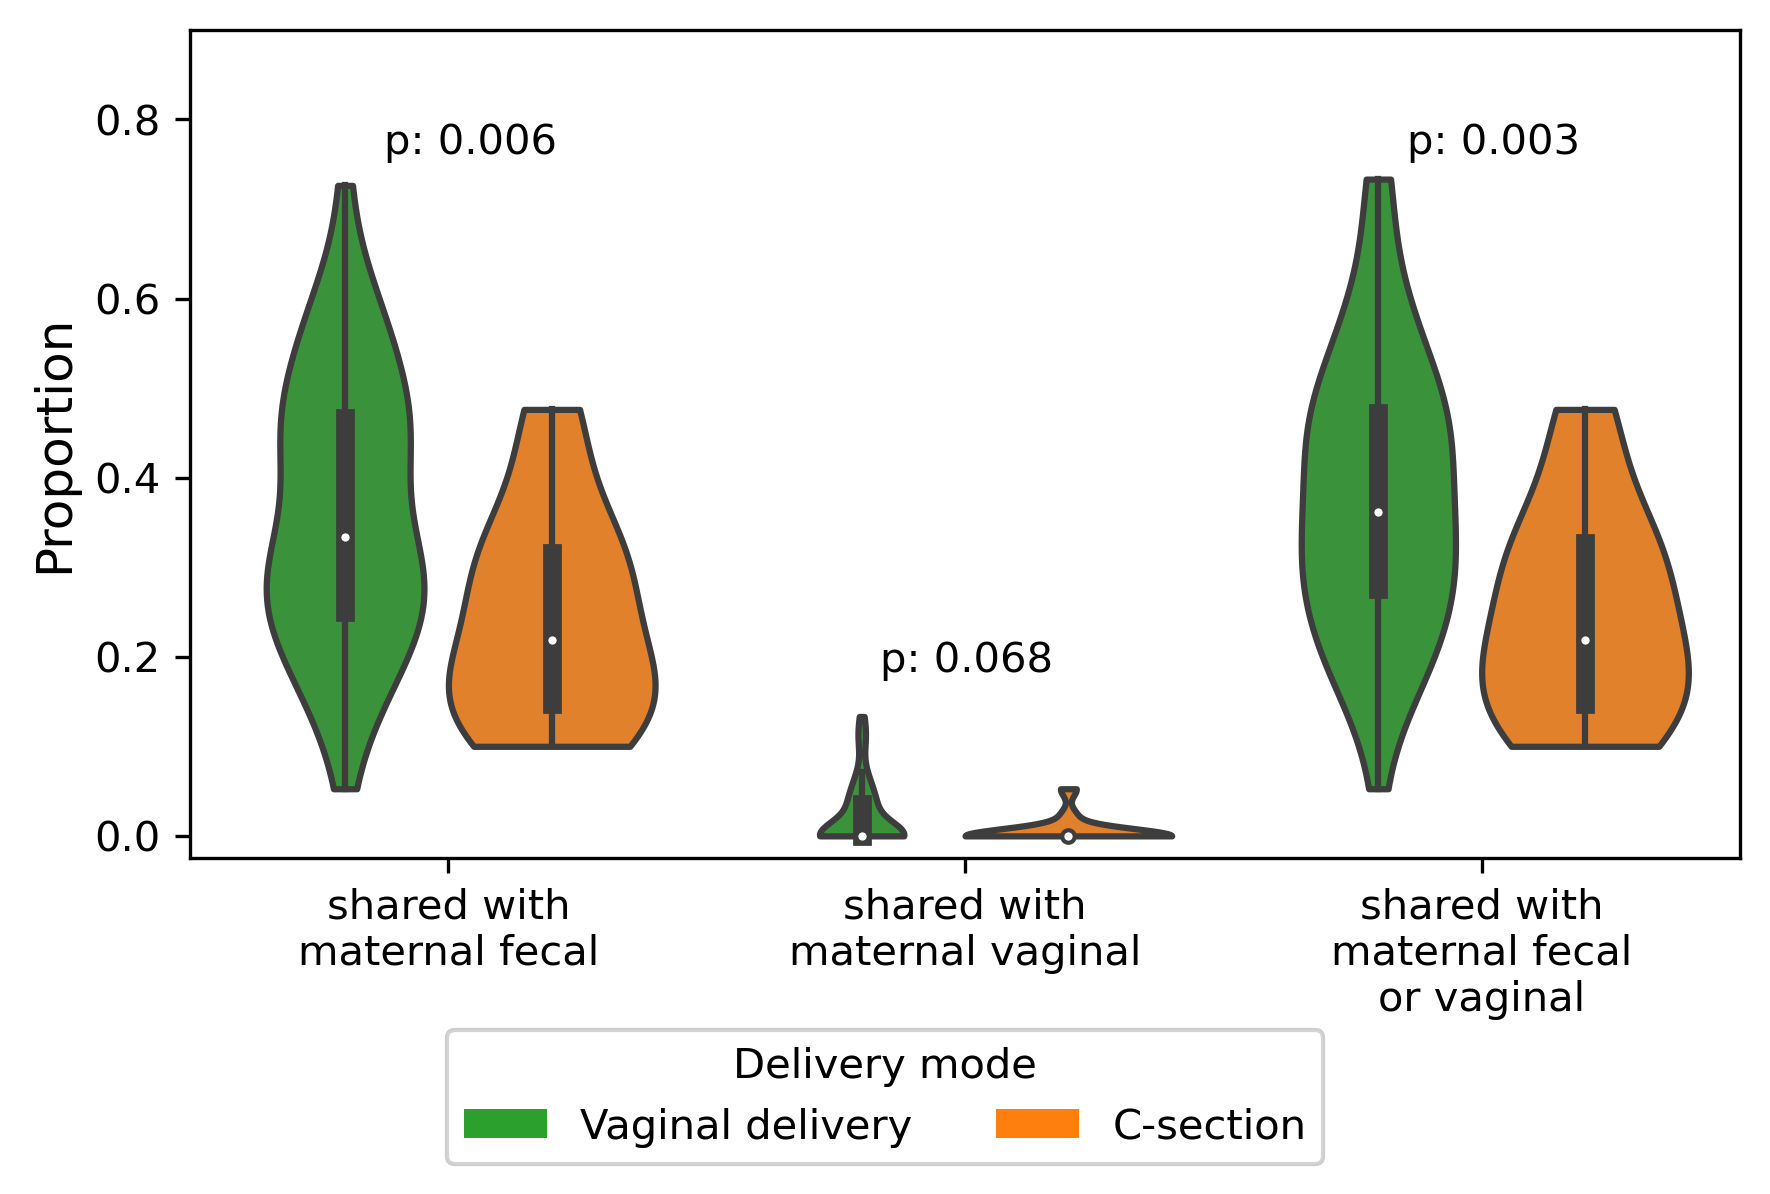

In [42]:
fig_1, axes_fig_1=plt.subplots(1, 1, figsize=(6, 4), dpi=300) 


### violin plot
shared_pp_delivery_vis = \
    sn.violinplot(ax=axes_fig_1,
                  x='variable',
                  y='value',
                  data=per_preg_species_p_vis,
                  cut=0, inner='box',
                  split=False,
                  width=0.8,
                  dodge=True,
                  box_width=0.4,
                  hue='birth_delivm',
                  palette={'vaginal delivery': '#2ca02c',
                           'c-section': '#ff7f0e'
                          },
                  hue_order=['vaginal delivery','c-section']
                 )

### set up axis parameters
shared_pp_delivery_vis.set_ylabel('Proportion',fontsize=12)
shared_pp_delivery_vis.set_yticks(np.arange(0,1.1,0.2))
shared_pp_delivery_vis.set_ylim(-0.025,0.9)
shared_pp_delivery_vis.set(xlabel=None)
shared_pp_delivery_vis.set_xticks(np.arange(0,3,1),
                                 labels=['shared with\nmaternal fecal',
                                         'shared with\nmaternal vaginal',
                                         'shared with\nmaternal fecal\nor vaginal'], fontsize=10)
shared_pp_delivery_vis.get_legend().remove()

### label p values
shared_pp_delivery_vis.text(0.125,0.85,
                            f"p: {per_preg_species_p_bydeliv_sum['mann-whitney u test p value for proportions'][0]:.3f}",
                            transform=shared_pp_delivery_vis.transAxes)
shared_pp_delivery_vis.text(0.445,0.225,
                            f"p: {per_preg_species_p_bydeliv_sum['mann-whitney u test p value for proportions'][1]:.3f}",
                            transform=shared_pp_delivery_vis.transAxes)
shared_pp_delivery_vis.text(0.785,0.85,
                            f"p: {per_preg_species_p_bydeliv_sum['mann-whitney u test p value for proportions'][2]:.3f}",
                            transform=shared_pp_delivery_vis.transAxes)

### Create a custom legend for exclusive breastfeeding
legend_elements_delivm = [
    Patch(facecolor='#2ca02c', label='Vaginal delivery'),
    Patch(facecolor='#ff7f0e', label='C-section')
]

legend_delivm = fig_1.legend(
    handles=legend_elements_delivm,
    loc='lower center', bbox_to_anchor=(0.5, 0), # Position it to the left
    ncol=len(legend_elements_delivm),
    title='Delivery mode'
)

# Ensure both legends are added to the figure.
# This line is crucial when adding multiple legends to a figure,
# as `fig.legend` typically replaces previous legends.
plt.gca().add_artist(legend_delivm)


plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust tight_layout to make space for the bottom legends


plt.show()
fig_1.savefig(f'{final_fig_dir}/fig1.png', dpi=300)
fig_1.savefig(f'{final_fig_dir}/fig1.pdf', dpi=300)

#### 3.2.3 Print Figure S1

In [43]:
## present data for the upset plot

### calculate the mean relative abundace of species by sample type and participant
### presence: defined as mean relative abundance > 0
mtp_species_meta = mtp_species_blongum_breakdown.join(mapping_tab, how='right')
mtp_species_overview = mtp_species_meta.groupby(
    ['mwgs_part_type','mwgs_spec_type']).mean(numeric_only=True)
mtp_species_overview_all_q = mtp_species_overview > 0 

### set up upset matrix for species data 
overview_all_ngp, overview_all_nip, overview_all_poly_id = build_upset_matrix(
    overlapped=mtp_species_overview_all_q.T[mtp_species_overview_all_q.T.apply(lambda x: any(x), axis=1)], 
    intersect_cols=[('1', '1'),
                    ('1', '7'),
                    ('2', '1')],
     inter_order=[2,4,8,6,12,10,14],
)

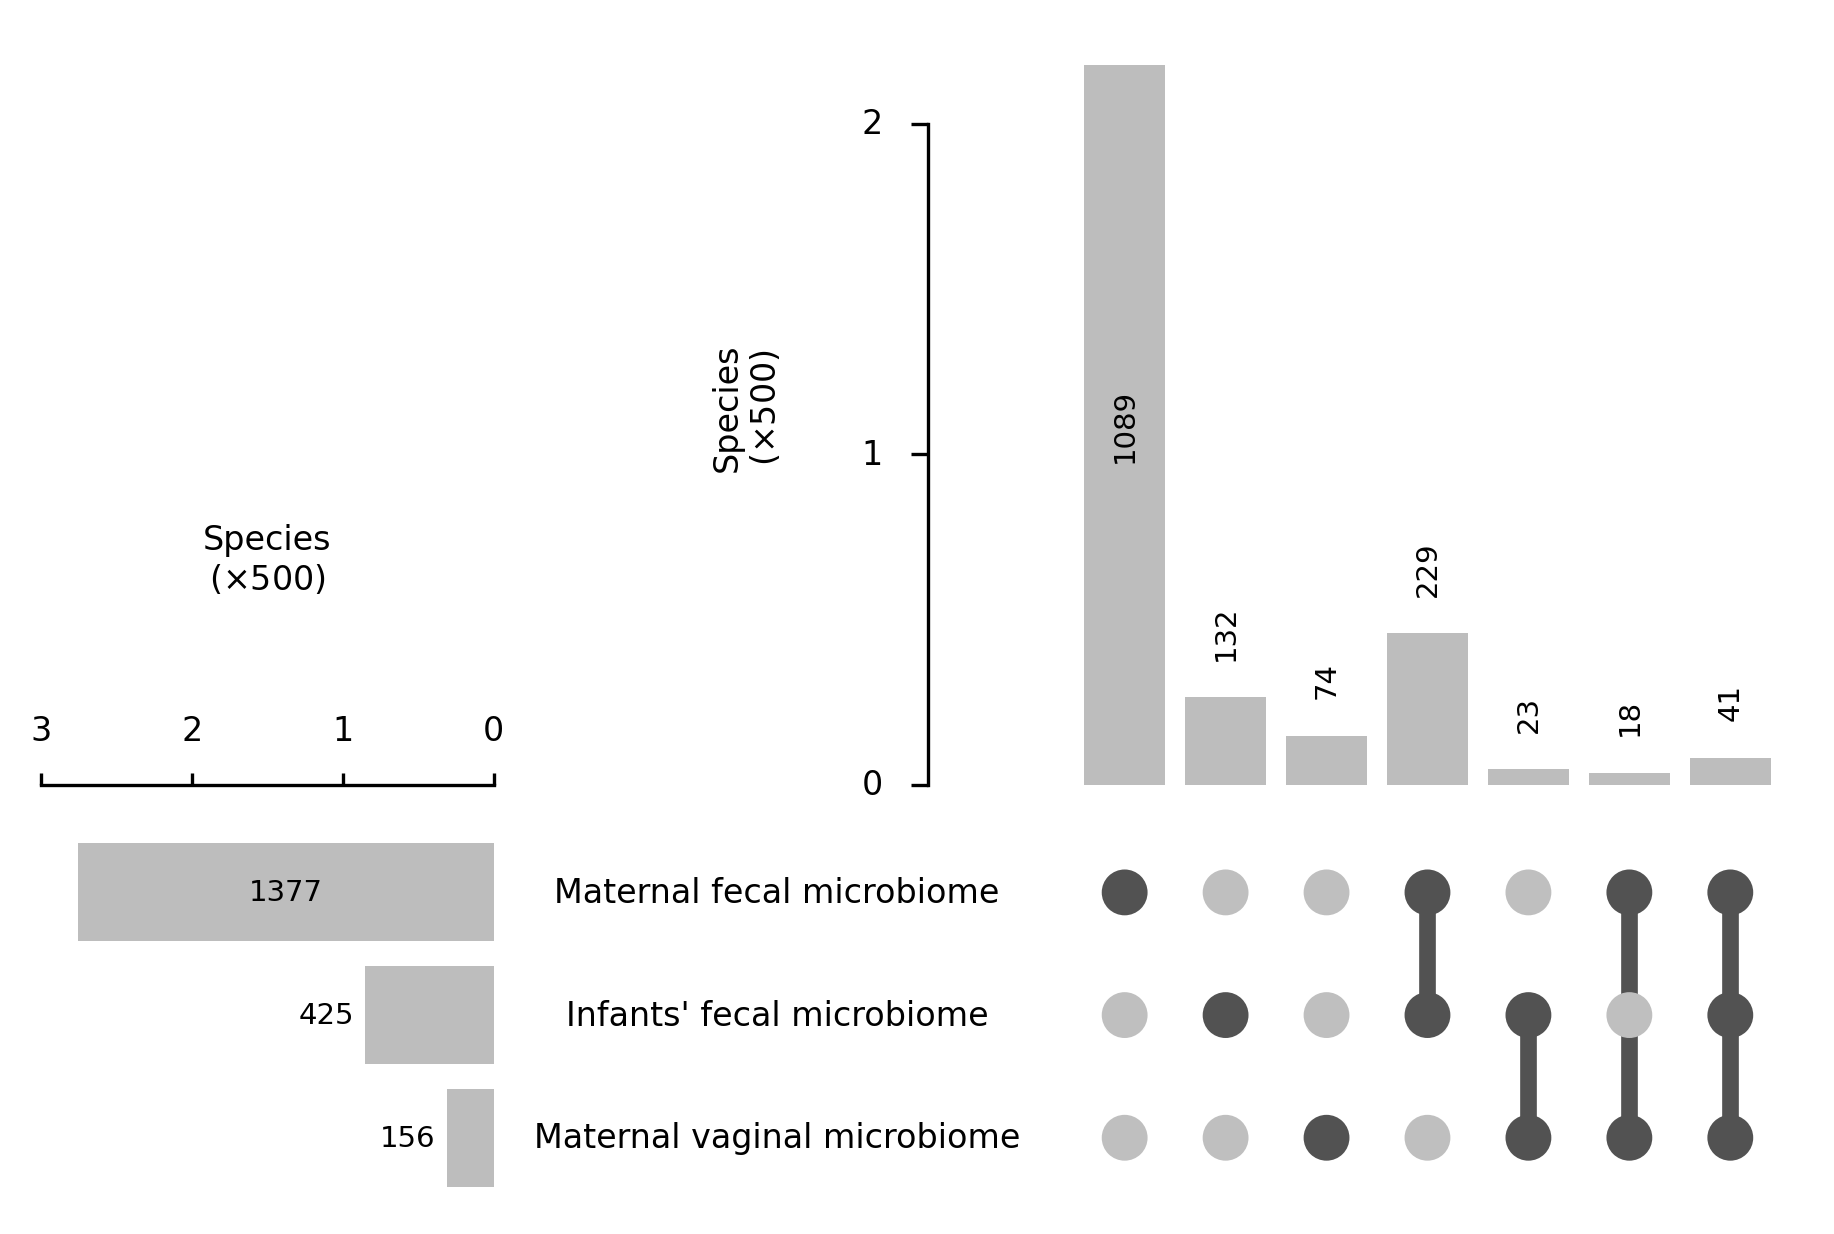

In [44]:
## upset figure with no filter

fig_s1 = plt.figure(dpi=300, constrained_layout=True, figsize=(6, 4))
plot_upset_part_only(fig_s1,
                     num_part=overview_all_ngp,
                     num_inter=overview_all_nip,
                     poly_id=overview_all_poly_id, 
                     spec_labels={('1', '1'): 'Maternal fecal microbiome',
                                  ('1', '7'): 'Maternal vaginal microbiome', 
                                  ('2', '1'): "Infants' fecal microbiome"},
                     off_text_inter=500, part_scale=500,
                     height_ratios=[2,1],
                     unit='Species\n($\\times 500$)'
                     # grouped_colors={'1': '#dbdbdb', '2': '#919191'}
                    )

plt.show()
fig_s1.savefig(f'{final_fig_dir}/suppfig1.png', dpi=300, bbox_inches='tight')
fig_s1.savefig(f'{final_fig_dir}/suppfig1.pdf', dpi=300, bbox_inches='tight')

#### 3.2.4 Print Supp Table 3

In [45]:
### maternal samples for longitudinal analysis for species sharing
mapping_tab_long_maternal = included_manifest_long[included_manifest_long['mwgs_part_type'] == '1'][['PregID', 'mwgs_spec_type', 'mwgs_part_type']]

In [46]:
## proportion sharing data: 0-1 month
mapping_tab_agegp1_kid = included_manifest_long[
    included_manifest_long['mwgs_age_month_g'] == '0-1'
].sort_values(by=['PregID', 'mwgs_age_month']).reset_index().groupby('PregID').first().reset_index()[
    ['PregID','mwgs_spec_type', 'mwgs_part_type', 'index']
].set_index('index')

mapping_tab_agegp1_full = pd.concat([mapping_tab_long_maternal,
                                     mapping_tab_agegp1_kid])

mtp_species_q_agegp1_meta = mtp_species_q.join(mapping_tab_agegp1_full, how='right').sort_values(
        ['PregID','mwgs_part_type','mwgs_spec_type']).drop(
        ['mwgs_part_type', 'mwgs_spec_type'], axis=1
    )

per_preg_species_agegp1 = pd.concat(
    [
    mtp_species_q_agegp1_meta.iloc[::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    ),
    mtp_species_q_agegp1_meta.iloc[1::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    ),
    mtp_species_q_agegp1_meta.iloc[2::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    )
    ], axis=1)

per_preg_species_agegp1.rename(columns={0: 'mom fecal',
                                 1: 'mom vaginal',
                                 2: 'kid fecal'}, inplace=True)

per_preg_species_agegp1['kid_fecal'] = per_preg_species_agegp1['kid fecal'].apply(len)
per_preg_species_agegp1['shared_parent_fecal'] = per_preg_species_agegp1.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom fecal'])),
    axis=1)
per_preg_species_agegp1['shared_parent_vaginal'] = per_preg_species_agegp1.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom vaginal'])),
    axis=1)
per_preg_species_agegp1['shared_parent'] = per_preg_species_agegp1.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom vaginal'].union(x['mom fecal']))),
    axis=1)

per_preg_species_agegp1_n = per_preg_species_agegp1[['kid_fecal',
                                                     'shared_parent_fecal',
                                                     'shared_parent_vaginal',
                                                     'shared_parent',
                                                    ]
].copy()

per_preg_species_agegp1_p = per_preg_species_agegp1_n.apply(lambda x: x/x['kid_fecal'], axis=1).drop('kid_fecal',axis=1)
per_preg_species_agegp1_p['age_group'] = '0-1 month'


In [47]:
## proportion sharing data: 2-4 month
mapping_tab_agegp2_kid = included_manifest_long[
    included_manifest_long['mwgs_age_month_g'] == '2-4'
].sort_values(by=['PregID', 'mwgs_age_month']).reset_index().groupby('PregID').first().reset_index()[
    ['PregID','mwgs_spec_type', 'mwgs_part_type', 'index']
].set_index('index')

mapping_tab_agegp2_full = pd.concat([mapping_tab_long_maternal,
                                     mapping_tab_agegp2_kid])

mtp_species_q_agegp2_meta = mtp_species_q.join(mapping_tab_agegp2_full, how='right').sort_values(
        ['PregID','mwgs_part_type','mwgs_spec_type']).drop(
        ['mwgs_part_type', 'mwgs_spec_type'], axis=1
    )

per_preg_species_agegp2 = pd.concat(
    [
    mtp_species_q_agegp2_meta.iloc[::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    ),
    mtp_species_q_agegp2_meta.iloc[1::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    ),
    mtp_species_q_agegp2_meta.iloc[2::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    )
    ], axis=1)

per_preg_species_agegp2.rename(columns={0: 'mom fecal',
                                 1: 'mom vaginal',
                                 2: 'kid fecal'}, inplace=True)

per_preg_species_agegp2['kid_fecal'] = per_preg_species_agegp2['kid fecal'].apply(len)
per_preg_species_agegp2['shared_parent_fecal'] = per_preg_species_agegp2.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom fecal'])),
    axis=1)
per_preg_species_agegp2['shared_parent_vaginal'] = per_preg_species_agegp2.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom vaginal'])),
    axis=1)
per_preg_species_agegp2['shared_parent'] = per_preg_species_agegp2.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom vaginal'].union(x['mom fecal']))),
    axis=1)

per_preg_species_agegp2_n = per_preg_species_agegp2[['kid_fecal',
                                                     'shared_parent_fecal',
                                                     'shared_parent_vaginal',
                                                     'shared_parent'
                                                    ]
].copy()

per_preg_species_agegp2_p = per_preg_species_agegp2_n.apply(lambda x: x/x['kid_fecal'], axis=1).drop('kid_fecal',axis=1)

per_preg_species_agegp2_p['age_group'] = '2-4 month'

In [48]:
## proportion sharing data: 5-7 month
mapping_tab_agegp3_kid = included_manifest_long[
    included_manifest_long['mwgs_age_month_g'] == '5-7'
].sort_values(by=['PregID', 'mwgs_age_month']).reset_index().groupby('PregID').first().reset_index()[
    ['PregID','mwgs_spec_type', 'mwgs_part_type', 'index']
].set_index('index')

mapping_tab_agegp3_full = pd.concat([mapping_tab_long_maternal,
                                     mapping_tab_agegp3_kid])

mtp_species_q_agegp3_meta = mtp_species_q.join(mapping_tab_agegp3_full, how='right').sort_values(
        ['PregID','mwgs_part_type','mwgs_spec_type']).drop(
        ['mwgs_part_type', 'mwgs_spec_type'], axis=1
    )

per_preg_species_agegp3 = pd.concat(
    [
    mtp_species_q_agegp3_meta.iloc[::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    ),
    mtp_species_q_agegp3_meta.iloc[1::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    ),
    mtp_species_q_agegp3_meta.iloc[2::3].set_index('PregID').apply(
        lambda x: set([sp for sp in mtp_species_name if x[sp]]), axis=1
    )
    ], axis=1)

per_preg_species_agegp3.rename(columns={0: 'mom fecal',
                                 1: 'mom vaginal',
                                 2: 'kid fecal'}, inplace=True)

per_preg_species_agegp3['kid_fecal'] = per_preg_species_agegp3['kid fecal'].apply(len)
per_preg_species_agegp3['shared_parent_fecal'] = per_preg_species_agegp3.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom fecal'])),
    axis=1)
per_preg_species_agegp3['shared_parent_vaginal'] = per_preg_species_agegp3.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom vaginal'])),
    axis=1)
per_preg_species_agegp3['shared_parent'] = per_preg_species_agegp3.apply(
    lambda x: len(x['kid fecal'].intersection(x['mom vaginal'].union(x['mom fecal']))),
    axis=1)

per_preg_species_agegp3_n = per_preg_species_agegp3[['kid_fecal',
                                                     'shared_parent_fecal',
                                                     'shared_parent_vaginal',
                                                     'shared_parent'
                                                    ]
].copy()

per_preg_species_agegp3_p = per_preg_species_agegp3_n.apply(lambda x: x/x['kid_fecal'], axis=1).drop('kid_fecal',axis=1)

per_preg_species_agegp3_p['age_group'] = '5-7 month'

In [49]:
per_preg_species_long_p = pd.concat(
    [
        per_preg_species_agegp1_p,
        per_preg_species_agegp2_p,
        per_preg_species_agegp3_p
    ])

In [50]:
per_preg_species_long_p.reset_index(inplace=True)

##### proportion of species shared with maternal vaginal or fecal across age group

In [51]:
per_preg_species_long_p.groupby('age_group')['shared_parent'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
0-1 month,27.0,0.304406,0.165806,0.052632,0.173993,0.347826,0.381048,0.666667
2-4 month,27.0,0.347971,0.160552,0.117647,0.220486,0.352941,0.474074,0.733333
5-7 month,27.0,0.308339,0.125077,0.090909,0.208947,0.288889,0.397368,0.520000


In [52]:
## fit mixed effect models (with age group, null): ML
long_species_share_overall_agegp = smf.mixedlm("shared_parent ~ age_group",
                                             per_preg_species_long_p,
                                             groups=per_preg_species_long_p['PregID']).fit(reml=False)

long_species_share_overall_null = smf.mixedlm("shared_parent ~ 1",
                                             per_preg_species_long_p,
                                             groups=per_preg_species_long_p['PregID']).fit(reml=False)

In [53]:
## likelihood ratio test
long_species_share_overall_LR_statistic = -2 * (long_species_share_overall_null.llf - long_species_share_overall_agegp.llf)
long_species_share_overall_df_diff = long_species_share_overall_agegp.df_modelwc - long_species_share_overall_null.df_modelwc
long_species_share_overall_LR_p_value = \
    scipy.stats.chi2.sf(
        long_species_share_overall_LR_statistic,
        long_species_share_overall_df_diff
    )
print(f"P value of LR test for age effect on proportions shared with maternal vaginal or fecal: {long_species_share_overall_LR_p_value: .3f}")

P value of LR test for age effect on proportions shared with maternal vaginal or fecal:  0.145


##### proportion of species shared with maternal feces across age group

In [54]:
per_preg_species_long_p.groupby('age_group')['shared_parent_fecal'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
0-1 month,27.0,0.284071,0.167043,0.000000,0.140394,0.280000,0.378734,0.666667
2-4 month,27.0,0.329963,0.152090,0.117647,0.220486,0.294118,0.474074,0.600000
5-7 month,27.0,0.297188,0.129639,0.070175,0.196154,0.285714,0.397368,0.518519


In [55]:
## fit mixed effect models (with age group, null): ML
long_species_share_fecal_agegp = smf.mixedlm("shared_parent_fecal ~ age_group",
                                             per_preg_species_long_p,
                                             groups=per_preg_species_long_p['PregID']).fit(reml=False)

long_species_share_fecal_null = smf.mixedlm("shared_parent_fecal ~ 1",
                                             per_preg_species_long_p,
                                             groups=per_preg_species_long_p['PregID']).fit(reml=False)

In [56]:
## likelihood ratio test
long_species_share_fecal_LR_statistic = -2 * (long_species_share_fecal_null.llf - long_species_share_fecal_agegp.llf)
long_species_share_fecal_df_diff = long_species_share_fecal_agegp.df_modelwc - long_species_share_fecal_null.df_modelwc
long_species_share_fecal_LR_p_value = \
    scipy.stats.chi2.sf(
        long_species_share_fecal_LR_statistic,
        long_species_share_fecal_df_diff
    )
print(f"P value of LR test for age effect on proportions shared with maternal fecal: {long_species_share_fecal_LR_p_value: .3f}")

P value of LR test for age effect on proportions shared with maternal fecal:  0.140


##### proportion of species shared with maternal vaginal across age group

In [57]:
per_preg_species_long_p.groupby('age_group')['shared_parent_vaginal'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
0-1 month,27.0,0.021364,0.049985,0.0,0.0,0.0,0.033120,0.250000
2-4 month,27.0,0.019959,0.034479,0.0,0.0,0.0,0.028992,0.133333
5-7 month,27.0,0.012542,0.020025,0.0,0.0,0.0,0.026334,0.071429


In [58]:
## fit mixed effect models (with age group, null): ML
long_species_share_vaginal_agegp = smf.mixedlm("shared_parent_vaginal ~ age_group",
                                             per_preg_species_long_p,
                                             groups=per_preg_species_long_p['PregID']).fit(reml=False)

long_species_share_vaginal_null = smf.mixedlm("shared_parent_vaginal ~ 1",
                                             per_preg_species_long_p,
                                             groups=per_preg_species_long_p['PregID']).fit(reml=False)

/opt/conda/envs/qiime2-2023.7/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/envs/qiime2-2023.7/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [59]:
## likelihood ratio test
long_species_share_vaginal_LR_statistic = -2 * (long_species_share_vaginal_null.llf - long_species_share_vaginal_agegp.llf)
long_species_share_vaginal_df_diff = long_species_share_vaginal_agegp.df_modelwc - long_species_share_vaginal_null.df_modelwc
long_species_share_vaginal_LR_p_value = \
    scipy.stats.chi2.sf(
        long_species_share_vaginal_LR_statistic,
        long_species_share_vaginal_df_diff
    )
print(f"P value of LR test for age effect on proportions shared with maternal vaginal: {long_species_share_vaginal_LR_p_value: .3f}")

P value of LR test for age effect on proportions shared with maternal vaginal:  0.393


### 3.3 Proportion of maternal microbiome shared with gut microbiome (SGB with strain-level characterization): Figure 2,3 ; Table S5 and Table S6

#### 3.3.1 Table S5: fecal

In [60]:
## subset the transmission info file for fecal samples
strain_transmission_info_fecal = strain_transmission_info.loc[(strain_transmission_info['n_fecal_transmission'] > 0)|
                                                              (strain_transmission_info['n_parent_fecal'] > 0)
                                                             ].copy()

In [61]:
## create the result df for fecal strain transmission
strain_transmission_fecal_result = strain_transmission_info_fecal.copy()
strain_transmission_fecal_result[['n_transmission (p)',
                                  'repeat_sample_dist']] = ''
strain_transmission_fecal_result['long_infant_sample_avail'] = 0

In [62]:
## loop through to calculate these metrics from transmission records
### 1. number of dyad with any transmission events
### 2. the number of dyads with any tranmisssion and longitudianl infant samples
### 3. the distribution of number of samples for dyads with longitudinal infant samples

for index, row in strain_transmission_info_fecal.iterrows():    
    ## get the species name
    temp_species = row['species']

    if row['n_fecal_transmission'] == 0:
        strain_transmission_fecal_result.loc[
            index,
            ['long_infant_sample_avail', 'n_persistent_transmission',
             'min_age_transmision', 'max_age_transmission'
            ]
        ] = np.nan

        strain_transmission_fecal_result.loc[index, 'n_transmission (p)'] = '0 (0)'
        strain_transmission_fecal_result.loc[index, 'repeat_sample_dist'] = ''

    else:
    
        ## get the first transmission record per pregnancy
        temp_record = strain_transmission_records.loc[(strain_transmission_records['strain_clade'] == index) & 
                                                      (strain_transmission_records['ParentID'].isin(mtp_species_parent_fecal.index))].copy()
        temp_record_ft = temp_record.groupby('ParentID').first()
    
        ## longitudinal sample available
        temp_all_manifest = included_manifest.loc[included_manifest.index.isin(eval(row['included_sample']))]

        ## transmission family
        temp_trans_fam = temp_all_manifest[temp_all_manifest.index.isin(temp_record['ParentID'])]

        ## kid sample count with tranmssion
        temp_infant_count = temp_all_manifest[
            (temp_all_manifest['PregID'].isin(temp_trans_fam['PregID'])) &
            (temp_all_manifest['mwgs_part_type'] == '2')
        ]['PregID'].value_counts()
    

        #assign number of fecal transmission
        strain_transmission_fecal_result.loc[index, 'n_transmission (p)'] = f"{temp_record_ft.shape[0]} ({temp_record_ft.shape[0]*100/row['n_parent_fecal']: .1f})"
        strain_transmission_fecal_result.loc[index, 'long_infant_sample_avail'] = sum(temp_infant_count > 1)

        if sum(temp_infant_count > 1) > 0:
            temp_infant_long = temp_infant_count[temp_infant_count > 1].describe()
            strain_transmission_fecal_result.loc[index, 'repeat_sample_dist'] = \
                f"{temp_infant_long['50%']:.1f} ({temp_infant_long['min']:.1f}, {temp_infant_long['max']:.1f})"
    

In [63]:
supp_table5_fecal_withtransmission = \
    strain_transmission_fecal_result[
        ['species', 'n_parent_fecal', 'n_unique_kid_fecal', 'n_transmission (p)',
         'long_infant_sample_avail', 'n_persistent_transmission',
         'min_age_transmision', 'max_age_transmission', 'repeat_sample_dist']
    ]

In [64]:
supp_table5_fecal_notransmission = \
    exclusively_exist_strain.loc[exclusively_exist_strain['n_parent_fecal'] > 0][
        ['species', 'n_parent_fecal', 'n_unique_kid_fecal']
    ].copy()
supp_table5_fecal_notransmission[
    ['long_infant_sample_avail', 'n_persistent_transmission',
     'min_age_transmision', 'max_age_transmission'
    ]
] = np.nan

supp_table5_fecal_notransmission['n_transmission (p)'] = '0 (0)'
supp_table5_fecal_notransmission['repeat_sample_dist'] = ''

In [65]:
supp_table5_fecal = pd.concat([supp_table5_fecal_withtransmission,
                               supp_table5_fecal_notransmission]).sort_values(by='species')

In [66]:
supp_table5_fecal.rename(columns={'n_parent_fecal': 'Mothers with strain profiled, n',
                                  'n_unique_kid_fecal': 'Infants with strain profiled in gut, n',
                                  'n_transmission (p)': 'Mothers sharing strain with their child, n (%)',
                                  'long_infant_sample_avail': 'Strain-sharing dyads with repeated infant samples, n',
                                  'n_persistent_transmission': 'Strain-sharing dyads with evidence of persistent sharing, n',
                                  'min_age_transmision': 'Infant age in months when strain sharing was first detected',
                                  'max_age_transmission': 'Infant age in months when strain sharing was last detected',
                                  'repeat_sample_dist': 'Repeated samples per strain-sharing dyad available'
                                 },
                         inplace=True)

In [67]:
supp_table5_fecal.to_csv(f'{final_fig_dir}/supp_table5_fecal.tsv', sep='\t')

#### 3.3.2 Table S5: vaginal

In [68]:
## subset the transmission info file for fecal samples
strain_transmission_info_vaginal = strain_transmission_info.loc[(strain_transmission_info['n_vaginal_transmission'] > 0)|
                                                                (strain_transmission_info['n_parent_vag'] > 0)].copy()

In [69]:
## create the result df for fecal strain transmission
strain_transmission_vaginal_result = strain_transmission_info_vaginal.copy()
strain_transmission_vaginal_result[['n_transmission (p)',
                                  'repeat_sample_dist']] = ''
strain_transmission_vaginal_result['long_infant_sample_avail'] = 0

In [70]:
## loop through to calculate these metrics from transmission records
### 1. number of dyad with any transmission events
### 2. the number of dyads with any tranmisssion and longitudianl infant samples
### 3. the distribution of number of samples for dyads with longitudinal infant samples

for index, row in strain_transmission_info_vaginal.iterrows():    
    ## get the species name
    temp_species = row['species']

    if row['n_vaginal_transmission'] == 0:
        strain_transmission_vaginal_result.loc[
            index,
            ['long_infant_sample_avail', 'n_persistent_transmission',
             'min_age_transmision', 'max_age_transmission'
            ]
        ] = np.nan

        strain_transmission_vaginal_result.loc[index, 'n_transmission (p)'] = '0 (0)'
        strain_transmission_vaginal_result.loc[index, 'repeat_sample_dist'] = ''

    else:
    
        ## get the first transmission record per pregnancy
        temp_record = strain_transmission_records.loc[(strain_transmission_records['strain_clade'] == index) & 
                                                      (strain_transmission_records['ParentID'].isin(mtp_species_parent_vaginal.index))].copy()
        temp_record_ft = temp_record.groupby('ParentID').first()
    
        ## longitudinal sample available
        temp_all_manifest = included_manifest.loc[included_manifest.index.isin(eval(row['included_sample']))]

        ## transmission family
        temp_trans_fam = temp_all_manifest[temp_all_manifest.index.isin(temp_record['ParentID'])]

        ## kid sample count with tranmssion
        temp_infant_count = temp_all_manifest[
            (temp_all_manifest['PregID'].isin(temp_trans_fam['PregID'])) &
            (temp_all_manifest['mwgs_part_type'] == '2')
        ]['PregID'].value_counts()
    

        #assign number of fecal transmission
        strain_transmission_vaginal_result.loc[index, 'n_transmission (p)'] = f"{temp_record_ft.shape[0]} ({temp_record_ft.shape[0]*100/row['n_parent_vag']: .1f})"
        strain_transmission_vaginal_result.loc[index, 'long_infant_sample_avail'] = sum(temp_infant_count > 1)

        if sum(temp_infant_count > 1) > 0:
            temp_infant_long = temp_infant_count[temp_infant_count > 1].describe()
            strain_transmission_vaginal_result.loc[index, 'repeat_sample_dist'] = \
                f"{temp_infant_long['50%']:.1f} ({temp_infant_long['min']:.1f}, {temp_infant_long['max']:.1f})"
    

In [71]:
supp_table5_vaginal_withtransmission = \
    strain_transmission_vaginal_result[
        ['species', 'n_parent_vag', 'n_unique_kid_fecal', 'n_transmission (p)',
         'long_infant_sample_avail', 'n_persistent_transmission',
         'min_age_transmision', 'max_age_transmission', 'repeat_sample_dist']
    ]

In [72]:
supp_table5_vaginal_notransmission = \
    exclusively_exist_strain.loc[exclusively_exist_strain['n_parent_vag'] > 0][
        ['species', 'n_parent_vag', 'n_unique_kid_fecal']
    ].copy()
supp_table5_vaginal_notransmission[
    ['long_infant_sample_avail', 'n_persistent_transmission',
     'min_age_transmision', 'max_age_transmission'
    ]
] = np.nan

supp_table5_vaginal_notransmission['n_transmission (p)'] = '0 (0)'
supp_table5_vaginal_notransmission['repeat_sample_dist'] = ''

In [73]:
supp_table5_vaginal = pd.concat([supp_table5_vaginal_withtransmission,
                                 supp_table5_vaginal_notransmission]).sort_values(by='species')

In [74]:
supp_table5_vaginal.rename(columns={'n_parent_vag': 'Mothers with strain profiled, n',
                                  'n_unique_kid_fecal': 'Infants with strain profiled in gut, n',
                                  'n_transmission (p)': 'Mothers sharing strain with their child, n (%)',
                                  'long_infant_sample_avail': 'Strain-sharing dyads with repeated infant samples, n',
                                  'n_persistent_transmission': 'Strain-sharing dyads with evidence of persistent sharing, n',
                                  'min_age_transmision': 'Infant age in months when strain sharing was first detected',
                                  'max_age_transmission': 'Infant age in months when strain sharing was last detected',
                                  'repeat_sample_dist': 'Repeated samples per strain-sharing dyad available'
                                 },
                         inplace=True)

In [75]:
supp_table5_vaginal

,species,"Mothers with strain profiled, n","Infants with strain profiled in gut, n","Mothers sharing strain with their child, n (%)","Strain-sharing dyads with repeated infant samples, n","Strain-sharing dyads with evidence of persistent sharing, n",Infant age in months when strain sharing was first detected,Infant age in months when strain sharing was last detected,Repeated samples per strain-sharing dyad available
Clade,,,,,,,,,
t__SGB17247,s__Bifidobacterium_breve,2,33,1 ( 50.0),1.0,1.0,1.0,6.0,"3.0 (3.0, 3.0)"
t__SGB17234,s__Bifidobacterium_dentium,2,13,2 ( 100.0),2.0,2.0,2.0,11.0,"2.5 (2.0, 3.0)"
t__subsp.infantis,s__Bifidobacterium_longum_subsp.infantis,1,12,1 ( 100.0),0.0,0.0,3.0,3.0,
t__SGB15342,s__Faecalibacterium_prausnitzii,1,6,0 (0),NaN,NaN,NaN,NaN,
t__SGB7045,s__Lactobacillus_crispatus,27,0,0 (0),NaN,NaN,NaN,NaN,
t__SGB7025,s__Lactobacillus_iners,25,0,0 (0),NaN,NaN,NaN,NaN,


In [76]:
supp_table5_vaginal.to_csv(f'{final_fig_dir}/supp_table5_vaginal.tsv', sep='\t')

#### 3.3.3 Table S6: fecal

In [77]:
## subset the transmission info file for fecal samples
fecal_any_transmission = strain_transmission_info.loc[(strain_transmission_info['n_fecal_transmission'] > 0)].copy()

In [78]:
## create dataframe to store transmission by delivery mode
fecal_any_transmission_result = fecal_any_transmission.copy()

fecal_any_transmission_result[
    ['n_dyad_fecal_transmission',
     'no_transmission',
     'n_vaginal_birth',
     'n_vaginal_birth_transmission',
     'n_vaginal_birth_notransmission',
     'n_csec',
     'n_csec_transmission',
     'n_csec_notransmission'
    ]
] = 0

fecal_any_transmission_result[
    ['p_transmission',
     'p_transmission_vaginal_birth',
     'p_transmission_csec',
    ]
] = ""


In [79]:
## loop through to calculate these metrics from transmission records
### 1. number of dyad with any transmission events
### 2. the number of dyads with any tranmisssion and longitudianl infant samples
### 3. the distribution of number of samples for dyads with longitudinal infant samples

for index, row in fecal_any_transmission.iterrows():    
    ## get the species name
    temp_species = row['species']

    ## get the first transmission record per pregnancy
    temp_record = strain_transmission_records.loc[(strain_transmission_records['strain_clade'] == index) & 
                                                  (strain_transmission_records['ParentID'].isin(mtp_species_parent_fecal.index))].copy()
    temp_record_ft = temp_record.groupby('ParentID').first()

    fecal_any_transmission_result.loc[index, 'n_dyad_fecal_transmission'] = temp_record_ft.shape[0]
    fecal_any_transmission_result.loc[index, 'no_transmission'] = \
        row['n_parent_fecal'] - temp_record_ft.shape[0]
    fecal_any_transmission_result.loc[index, 'p_transmission'] = f"{temp_record_ft.shape[0]/row['n_parent_fecal']:.3f} ({temp_record_ft.shape[0]}/{row['n_parent_fecal']})"

    
    ## generate transmission data per family
    temp_all_manifest = included_manifest.loc[(included_manifest.index.isin(eval(row['included_sample'])))&
                                              (included_manifest['mwgs_part_type'] == '1')].copy()
    temp_all_manifest['transmission'] = 0
    temp_all_manifest.loc[temp_all_manifest.index.isin(temp_record_ft.index), 'transmission'] = 1
    temp_trans_perfam = temp_all_manifest.groupby('PregID')['transmission'].first()

    ## merge with delivery mode
    temp_trans_perfam_meta =\
        pd.merge(temp_trans_perfam,
                 mapping_tab_fam,
                 left_index=True,
                 right_index=True,
                 how='inner')
    ## calculate the numbers by delivery mode (transmission)
    
    fecal_any_transmission_result.loc[index, 'n_vaginal_birth'] = temp_trans_perfam_meta[temp_trans_perfam_meta['birth_delivm'] == '1'].shape[0]
    fecal_any_transmission_result.loc[index, 'n_vaginal_birth_transmission'] = \
        temp_trans_perfam_meta[
            (temp_trans_perfam_meta['birth_delivm'] == '1') &
            (temp_trans_perfam_meta['transmission'] == 1)
        ].shape[0]
    fecal_any_transmission_result.loc[index, 'n_vaginal_birth_notransmission'] = \
        temp_trans_perfam_meta[
            (temp_trans_perfam_meta['birth_delivm'] == '1') &
            (temp_trans_perfam_meta['transmission'] == 0)
        ].shape[0]
    if temp_trans_perfam_meta[temp_trans_perfam_meta['birth_delivm'] == '1'].shape[0] == 0:
        fecal_any_transmission_result.loc[index, 'p_transmission_vaginal_birth'] = '-'
    else:
        fecal_any_transmission_result.loc[index, 'p_transmission_vaginal_birth'] = \
            f"""{fecal_any_transmission_result.loc[index, 'n_vaginal_birth_transmission']/fecal_any_transmission_result.loc[index, 'n_vaginal_birth']:.3f} 
                ({fecal_any_transmission_result.loc[index, 'n_vaginal_birth_transmission']}/{fecal_any_transmission_result.loc[index, 'n_vaginal_birth']})"""


    
    fecal_any_transmission_result.loc[index, 'n_csec'] = temp_trans_perfam_meta[temp_trans_perfam_meta['birth_delivm'] == '2'].shape[0]
    fecal_any_transmission_result.loc[index, 'n_csec_transmission'] = \
        temp_trans_perfam_meta[
            (temp_trans_perfam_meta['birth_delivm'] == '2') &
            (temp_trans_perfam_meta['transmission'] == 1)
        ].shape[0]
    fecal_any_transmission_result.loc[index, 'n_csec_notransmission'] = \
        temp_trans_perfam_meta[
            (temp_trans_perfam_meta['birth_delivm'] == '2') &
            (temp_trans_perfam_meta['transmission'] == 0)
        ].shape[0]
    if temp_trans_perfam_meta[temp_trans_perfam_meta['birth_delivm'] == '2'].shape[0] == 0:
        fecal_any_transmission_result.loc[index, 'p_transmission_csec'] = '-'
    else:
        fecal_any_transmission_result.loc[index, 'p_transmission_csec'] = \
            f"""{fecal_any_transmission_result.loc[index, 'n_csec_transmission']/fecal_any_transmission_result.loc[index, 'n_csec']:.3f} 
                ({fecal_any_transmission_result.loc[index, 'n_csec_transmission']}/{fecal_any_transmission_result.loc[index, 'n_csec']})"""
    

    

In [80]:
supp_table6_fecal = fecal_any_transmission_result[
    ['species',
     'p_transmission',
     'p_transmission_vaginal_birth',
     'p_transmission_csec',
    ]
].sort_values(by='species')

In [81]:
supp_table6_fecal.rename(columns={'p_transmission': 'Overall proportion strain sharing',
                                  'p_transmission_vaginal_birth': 'Proportion strain sharing among vaginal delivery',
                                  'p_transmission_csec': 'Proportion strain sharing among c-section'
                                 },
                         inplace=True)

In [82]:
supp_table6_fecal

,species,Overall proportion strain sharing,Proportion strain sharing among vaginal delivery,Proportion strain sharing among c-section
Clade,,,,
t__SGB9226,s__Akkermansia_muciniphila,0.048 (1/21),0.062 \n (1/16),0.000 \n (0/5)
t__SGB2318,s__Alistipes_putredinis,0.068 (3/44),0.094 \n (3/32),0.000 \n (0/12)
t__SGB4532,s__Anaerobutyricum_hallii,0.100 (1/10),0.000 \n (0/4),0.167 \n (1/6)
t__SGB1877,s__Bacteroides_caccae,0.125 (2/16),0.167 \n (2/12),0.000 \n (0/4)
t__SGB1855,s__Bacteroides_fragilis,0.500 (5/10),0.625 \n (5/8),0.000 \n (0/2)
t__SGB1830,s__Bacteroides_stercoris,0.083 (2/24),0.111 \n (2/18),0.000 \n (0/6)
t__SGB1861,s__Bacteroides_thetaiotaomicron,0.250 (6/24),0.333 \n (6/18),0.000 \n (0/6)
t__SGB1836,s__Bacteroides_uniformis,0.273 (9/33),0.286 \n (8/28),0.200 \n (1/5)
t__SGB1965,s__Barnesiella_intestinihominis,0.053 (1/19),0.083 \n (1/12),0.000 \n (0/7)


#### 3.3.4 Figure 2

In [83]:
def group_assign(var):
    if var in ['n_dyad_fecal_transmission', 'no_transmission']:
        return 'total'
    elif var in ['n_vaginal_birth_transmission', 'n_vaginal_birth_notransmission']:
        return 'vaginal delivery'
    else:
        return 'c-section'

In [84]:
## Bifido visualization data
strain_fecal_bifido_vis_data_wide = fecal_any_transmission_result.loc[
    fecal_any_transmission_result['species'].map(lambda x: 'Bifidobacterium' in x),
    ['species','n_dyad_fecal_transmission', 'no_transmission',
     'n_vaginal_birth_transmission', 'n_vaginal_birth_notransmission',
     'n_csec_transmission', 'n_csec_notransmission'
    ]
].copy()

strain_fecal_bifido_vis_data_wide['species'] = \
    strain_fecal_bifido_vis_data_wide['species'].replace({'s__Bifidobacterium_adolescentis': 'Bifidobacterium\nadolescentis',
                                                          's__Bifidobacterium_bifidum': 'Bifidobacterium\nbifidum',
                                                          's__Bifidobacterium_dentium': 'Bifidobacterium\ndentium',
                                                          's__Bifidobacterium_longum_subsp.longum': 'Bifidobacterium\nlongum\nsubsp.longum',
                                                          's__Bifidobacterium_pseudocatenulatum': 'Bifidobacterium\npseudocatenulatum'})

strain_fecal_bifido_vis_data_long = pd.melt(strain_fecal_bifido_vis_data_wide, id_vars = 'species')

strain_fecal_bifido_vis_data_long['group'] = strain_fecal_bifido_vis_data_long['variable'].map(group_assign)
strain_fecal_bifido_vis_data_long['strain sharing'] = strain_fecal_bifido_vis_data_long['variable'].map(lambda x: 'Yes' if x in ['n_dyad_fecal_transmission',
                                                                                                                                 'n_vaginal_birth_transmission',
                                                                                                                                 'n_csec_transmission'] else 'No')

strain_fecal_bifido_vis_data_long['species'] = \
    pd.Categorical(strain_fecal_bifido_vis_data_long['species'],
                   categories=['Bifidobacterium\ndentium',
                               'Bifidobacterium\nlongum\nsubsp.longum',
                               'Bifidobacterium\npseudocatenulatum',
                               'Bifidobacterium\nbifidum',
                               'Bifidobacterium\nadolescentis'
                              ],
                   ordered=True
                  )

strain_fecal_bifido_vis_data_long['group'] = \
    pd.Categorical(strain_fecal_bifido_vis_data_long['group'],
                   categories=['c-section',
                               'vaginal delivery',
                               'total'
                              ],
                   ordered=True
                  )

strain_fecal_bifido_vis_data_long['strain sharing'] = \
    pd.Categorical(strain_fecal_bifido_vis_data_long['strain sharing'],
                   categories=['No', 'Yes'],
                   ordered=True
                  )

strain_fecal_bifido_vis_data_long.sort_values(by=['species','group','strain sharing'], inplace=True)
strain_fecal_bifido_vis_data_pivot = \
    strain_fecal_bifido_vis_data_long.pivot_table(index=['species', 'group'],
                                                  columns='strain sharing',
                                                  values='value',
                                                  fill_value=0).reset_index()


In [85]:
## Bacteroides visualization data
strain_fecal_bacteroides_vis_data_wide = fecal_any_transmission_result.loc[
    fecal_any_transmission_result['species'].map(lambda x: 'Bacteroides' in x),
    ['species','n_dyad_fecal_transmission', 'no_transmission',
     'n_vaginal_birth_transmission', 'n_vaginal_birth_notransmission',
     'n_csec_transmission', 'n_csec_notransmission'
    ]
].copy()

strain_fecal_bacteroides_vis_data_wide['species'] = \
    strain_fecal_bacteroides_vis_data_wide['species'].replace({'s__Bacteroides_caccae': 'Bacteroides\ncaccae',
                                                               's__Bacteroides_fragilis': 'Bacteroides\nfragilis',
                                                               's__Bacteroides_stercoris': 'Bacteroides\nstercoris',
                                                               's__Bacteroides_thetaiotaomicron': 'Bacteroides\nthetaiotaomicron',
                                                               's__Bacteroides_uniformis': 'Bacteroides\nuniformis'})

strain_fecal_bacteroides_vis_data_long = pd.melt(strain_fecal_bacteroides_vis_data_wide, id_vars = 'species')

strain_fecal_bacteroides_vis_data_long['group'] = strain_fecal_bacteroides_vis_data_long['variable'].map(group_assign)
strain_fecal_bacteroides_vis_data_long['strain sharing'] = strain_fecal_bacteroides_vis_data_long['variable'].map(lambda x: 'Yes' if x in ['n_dyad_fecal_transmission',
                                                                                                                                           'n_vaginal_birth_transmission',
                                                                                                                                           'n_csec_transmission'] else 'No')

strain_fecal_bacteroides_vis_data_long['species'] = \
    pd.Categorical(strain_fecal_bacteroides_vis_data_long['species'],
                   categories=['Bacteroides\nfragilis',
                               'Bacteroides\ncaccae',
                               'Bacteroides\nstercoris',
                               'Bacteroides\nthetaiotaomicron',
                               'Bacteroides\nuniformis'
                              ],
                   ordered=True
                  )

strain_fecal_bacteroides_vis_data_long['group'] = \
    pd.Categorical(strain_fecal_bacteroides_vis_data_long['group'],
                   categories=['c-section',
                               'vaginal delivery',
                               'total'
                              ],
                   ordered=True
                  )

strain_fecal_bacteroides_vis_data_long['strain sharing'] = \
    pd.Categorical(strain_fecal_bacteroides_vis_data_long['strain sharing'],
                   categories=['No', 'Yes'],
                   ordered=True
                  )

strain_fecal_bacteroides_vis_data_long.sort_values(by=['species','group','strain sharing'], inplace=True)
strain_fecal_bacteroides_vis_data_pivot = \
    strain_fecal_bacteroides_vis_data_long.pivot_table(index=['species', 'group'],
                                                  columns='strain sharing',
                                                  values='value',
                                                  fill_value=0).reset_index()


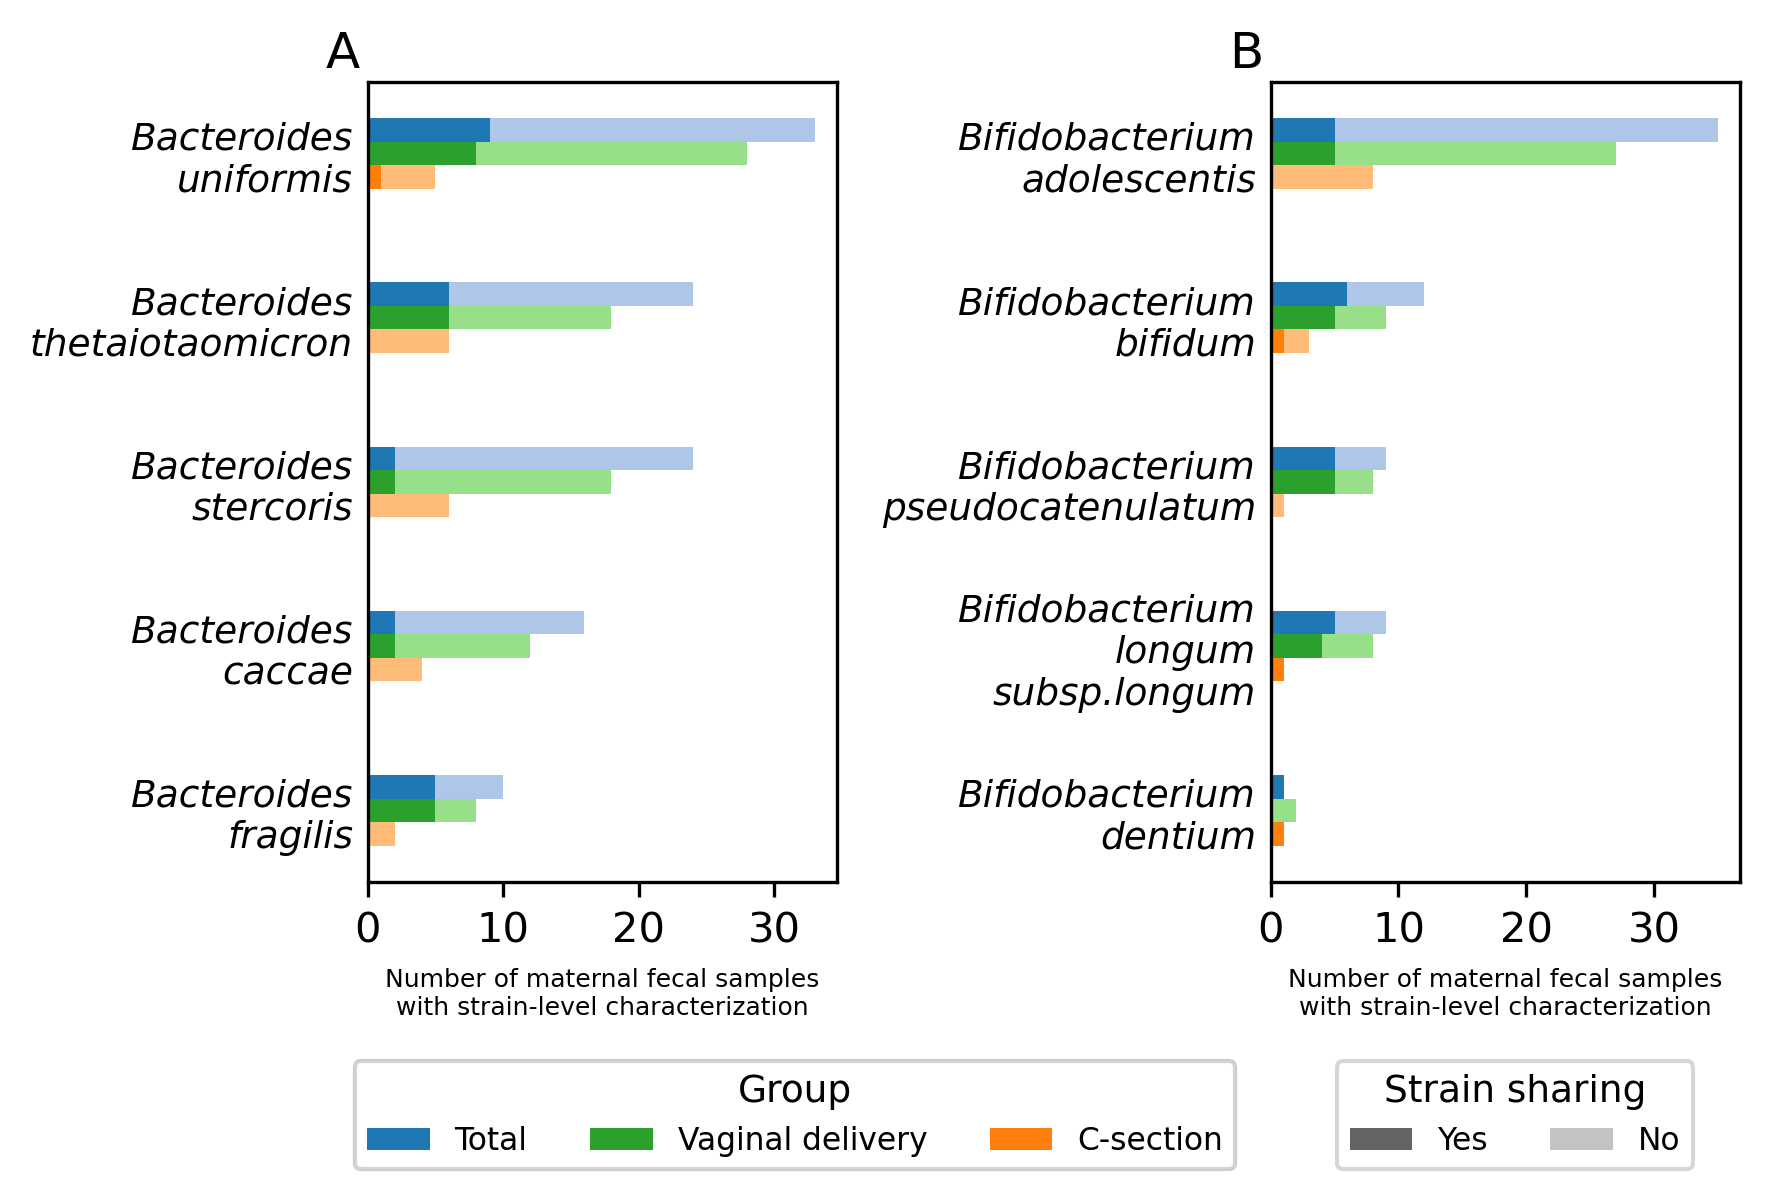

In [86]:
# Set up the matplotlib figure with two subplots side-by-side
# Adjust figsize to accommodate two plots and a bottom legend
fig_2, axes_fig_2=plt.subplots(1, 2, figsize=(6, 4), dpi=300)  # 1 row, 2 columns

 
# Calculate the height for each individual bar.
bar_height = 0.1 

# Determine the spacing between the species
species_spacing = 0.4 # Space between each main species

# pick up color for group and strain sharing
group_colors = {
    'total': ('#1f77b4', '#aec7e8'), # Darker and Lighter Blue (strain sharing, no strain sharing)
    'vaginal delivery': ('#2ca02c', '#98df8a'), # Darker and Lighter Green
    'c-section': ('#ff7f0e','#ffbb78')  # Darker and Lighter Orange
}

def plot_stacked_bar_chart(ax, df, title, subplot_label):

    # Define the x-axis species and groups from the pivoted DataFrame.
    species_unique = df['species'].unique()
    
    group_unique = df['group'].unique()

    num_groups = len(group_unique)
    # Calculate positions for each individual bar on the y-ayis.
    # These positions are for the actual bars.
    y_positions = []
    group_center_positions = []
    group_labels_only = []
    for i, y_species in enumerate(species_unique):
        # Calculate the base position for the current main species's first group bar.
        base_pos = i * (bar_height * num_groups + species_spacing)
        for j, group_name in enumerate(group_unique):
            # Position for each subgroup bar within the current species.
            pos = base_pos + j * bar_height
            y_positions.append(pos)
        # Calculate the starting y-position of the first bar in this group's cluster.
        start_of_group_cluster = i * (bar_height * num_groups + species_spacing)
        # Calculate the ending y-position of the last bar in this group's cluster.
        end_of_group_cluster = start_of_group_cluster + (num_groups - 1) * bar_height
        # The center is the average of the start and end positions.
        center_of_group_label = (start_of_group_cluster + end_of_group_cluster) / 2
        group_center_positions.append(center_of_group_label)
        group_labels_only.append(y_species) # Only the group name for the y-axis label

    
    # Prepare lists for component values and their respective colors for all bars
    comp_x_values = []
    comp_y_values = []
    colors_comp_x = []
    colors_comp_y = []

    for i, y_species in enumerate(species_unique):
        for j, group_name in enumerate(group_unique):
            # Retrieve the 'Yes' and 'No' values for the current group and subgroup.
            val_x = df[(df['species'] == y_species) & (df['group'] == group_name)]['Yes'].iloc[0]
            val_y = df[(df['species'] == y_species) & (df['group'] == group_name)]['No'].iloc[0]

            comp_x_values.append(val_x)
            comp_y_values.append(val_y)

            # Append the appropriate shade for Component X and Component Y based on the subgroup.
            colors_comp_x.append(group_colors[group_name][0]) # Darker shade for Component X
            colors_comp_y.append(group_colors[group_name][1]) # Lighter shade for Component Y

    # Plot 'Yes' (the bottom part of the stacked bars)
    # The 'color' argument now takes a list, applying a different color to each bar based on its subgroup.
    ax.barh(y_positions, comp_x_values, bar_height, color=colors_comp_x)

    # Plot 'No' (the top part of the stacked bars)
    # It's stacked on top of Component X, and its colors also vary by subgroup.
    ax.barh(y_positions, comp_y_values, bar_height, left=comp_x_values, color=colors_comp_y)


    # Customize the plot for better readability.
    ax.set_xlabel('Number of maternal fecal samples\nwith strain-level characterization',
                 fontsize=6)
    ax.set_xticks([0,10,20,30], fontsize=9)

    # Set x-axis ticks to the calculated center positions and apply only group names as labels.
    # ax.set_title(title, fontstyle='italic')
    # ax.set_title(subplot_label, loc='left', fontsize='medium')
    ax.text(0,1,
            subplot_label,
            transform=(ax.transAxes + ScaledTranslation(-10/72, +1/72, fig_2.dpi_scale_trans)),
            fontsize=12, va='bottom')
    ax.set_yticks(group_center_positions) # No rotation needed if labels are short
    ax.set_yticklabels(group_labels_only, fontstyle='italic', fontsize=9)
    ax.tick_params(axis='y', length=0)
    ax.grid(False)

# Plot on the first subplot
plot_stacked_bar_chart(axes_fig_2[0], strain_fecal_bacteroides_vis_data_pivot, 'Bacteroides', 'A')
# Plot on the second subplot
plot_stacked_bar_chart(axes_fig_2[1], strain_fecal_bifido_vis_data_pivot, 'Bifidobacterium', 'B')




# Create a custom legend for Subgroups.
legend_elements_group = [
    Patch(facecolor=group_colors['total'][0], label='Total'),
    Patch(facecolor=group_colors['vaginal delivery'][0], label='Vaginal delivery'),
    Patch(facecolor=group_colors['c-section'][0], label='C-section')
]

# Create a custom legend for Stack Components.
legend_elements_strainsharing = [
    Patch(facecolor='#646464', label='Yes'), # Darker shade example
    Patch(facecolor='#c3c3c3', label='No')  # Lighter shade example
]


# Add two separate legends at the bottom for the entire figure
# Adjust bbox_to_anchor for fine-tuning position of each legend
# The first legend (Subgroup)
legend_group = fig_2.legend(handles=legend_elements_group,
                             loc='lower center', bbox_to_anchor=(0.45, 0), # Position it to the left
                             ncol=len(legend_elements_group),
                             fontsize=7.5,
                             title_fontsize=9,
                             title='Group')

# The second legend (Stack Component)
legend_strainsharing = fig_2.legend(handles=legend_elements_strainsharing,
                              loc='lower center', bbox_to_anchor=(0.85, 0), # Position it to the right
                              ncol=len(legend_elements_strainsharing),
                              fontsize=7.5,
                              title_fontsize=9,
                              title='Strain sharing')

# Ensure both legends are added to the figure.
# This line is crucial when adding multiple legends to a figure,
# as `fig.legend` typically replaces previous legends.
plt.gca().add_artist(legend_group)


plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust tight_layout to make space for the bottom legends


plt.show()

fig_2.savefig(f'{final_fig_dir}/fig2.png', dpi=300)
fig_2.savefig(f'{final_fig_dir}/fig2.pdf', dpi=300)

#### 3.3.5 Bifidobacterium and Bacteroides sharing by delivery mode: test

In [87]:
## data for strain-sharing for any bacteroides
bacteroides_transmission_test = []

for strain in list(strain_fecal_bacteroides_vis_data_wide.index):

    fecal_manifest = included_manifest[included_manifest['mwgs_spec_type'] == '1']
    
    temp_transmission = included_manifest.loc[
        strain_transmission_records[strain_transmission_records['strain_clade'] == strain]['ParentID'].unique()
    ][['PregID']]

    temp_transmission_withmeta = pd.merge(temp_transmission,
                                          mapping_tab_fam, left_on='PregID', right_index=True)
    temp_transmission_withmeta['transmission'] = 1

    temp_no_transmission = included_manifest.loc[
        eval(strain_transmission_info.loc[strain]['included_sample'])
    ][
        (included_manifest['mwgs_part_type'] == '1') &
        (~included_manifest.index.isin(temp_transmission_withmeta.index))
    ][['PregID']]

    temp_no_transmission_withmeta = pd.merge(temp_no_transmission,
                                             mapping_tab_fam, left_on='PregID', right_index=True)
    temp_no_transmission_withmeta['transmission'] = 0

    temp_withmeta = pd.concat([temp_transmission_withmeta, temp_no_transmission_withmeta])

    temp_withmeta = temp_withmeta[temp_withmeta.index.isin(fecal_manifest.index)]

    bacteroides_transmission_test.append(temp_withmeta)

bacteroides_transmission_data = pd.concat(bacteroides_transmission_test)

/tmp/ipykernel_3528/3592686651.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[
/tmp/ipykernel_3528/3592686651.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[
/tmp/ipykernel_3528/3592686651.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[
/tmp/ipykernel_3528/3592686651.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[
/tmp/ipykernel_3528/3592686651.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[


In [88]:
## change the delivery mode to categorical variable
bacteroides_transmission_data['birth_delivm'] = \
    bacteroides_transmission_data['birth_delivm'].replace({'1': 'vaginal delivery',
                                                           '2': 'c-section'})

bacteroides_transmission_data['birth_delivm'] = \
    pd.Categorical(bacteroides_transmission_data['birth_delivm'],
                   categories=['c-section', 'vaginal delivery'],
                   ordered=True)

In [89]:
## fit geeglm model for transmission by birth delivery mode: any bacteroides
bacteroides_strain_share_bydeliv = smf.gee("transmission ~ birth_delivm",
                                           "PregID",
                                           data=bacteroides_transmission_data,
                                           family=sm.families.Binomial(),
                                           cov_struct=sm.cov_struct.Exchangeable()
                                          ).fit()

print(bacteroides_strain_share_bydeliv.summary())

                               GEE Regression Results                              
Dep. Variable:                transmission   No. Observations:                  107
Model:                                 GEE   No. clusters:                       51
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   5
Family:                           Binomial   Mean cluster size:                 2.1
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Mon, 23 Feb 2026   Scale:                           1.000
Covariance type:                    robust   Time:                         21:41:18
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.063

In [90]:
## data for strain-sharing for any bifidobacterium
bifido_transmission_test = []

for strain in list(strain_fecal_bifido_vis_data_wide.index):

    fecal_manifest = included_manifest[included_manifest['mwgs_spec_type'] == '1']
    
    temp_transmission = included_manifest.loc[
        strain_transmission_records[strain_transmission_records['strain_clade'] == strain]['ParentID'].unique()
    ][['PregID']]

    temp_transmission_withmeta = pd.merge(temp_transmission,
                                          mapping_tab_fam, left_on='PregID', right_index=True)
    temp_transmission_withmeta['transmission'] = 1

    temp_no_transmission = included_manifest.loc[
        eval(strain_transmission_info.loc[strain]['included_sample'])
    ][
        (included_manifest['mwgs_part_type'] == '1') &
        (~included_manifest.index.isin(temp_transmission_withmeta.index))
    ][['PregID']]

    temp_no_transmission_withmeta = pd.merge(temp_no_transmission,
                                             mapping_tab_fam, left_on='PregID', right_index=True)
    temp_no_transmission_withmeta['transmission'] = 0

    temp_withmeta = pd.concat([temp_transmission_withmeta, temp_no_transmission_withmeta])

    temp_withmeta = temp_withmeta[temp_withmeta.index.isin(fecal_manifest.index)]

    bifido_transmission_test.append(temp_withmeta)

bifido_transmission_data = pd.concat(bifido_transmission_test)

/tmp/ipykernel_3528/189455376.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[
/tmp/ipykernel_3528/189455376.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[
/tmp/ipykernel_3528/189455376.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[
/tmp/ipykernel_3528/189455376.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[
/tmp/ipykernel_3528/189455376.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_no_transmission = included_manifest.loc[


In [91]:
## change the delivery mode to categorical variable
bifido_transmission_data['birth_delivm'] = \
    bifido_transmission_data['birth_delivm'].replace({'1': 'vaginal delivery',
                                                           '2': 'c-section'})

bifido_transmission_data['birth_delivm'] = \
    pd.Categorical(bifido_transmission_data['birth_delivm'],
                   categories=['c-section', 'vaginal delivery'],
                   ordered=True)

In [92]:
## fit geeglm model for transmission by birth delivery mode: any bifidobacterium
bifido_strain_share_bydeliv = smf.gee("transmission ~ birth_delivm",
                                           "PregID",
                                           data=bifido_transmission_data,
                                           family=sm.families.Binomial(),
                                           cov_struct=sm.cov_struct.Exchangeable()
                                          ).fit()

print(bifido_strain_share_bydeliv.summary())

                               GEE Regression Results                              
Dep. Variable:                transmission   No. Observations:                   66
Model:                                 GEE   No. clusters:                       46
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   3
Family:                           Binomial   Mean cluster size:                 1.4
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Mon, 23 Feb 2026   Scale:                           1.000
Covariance type:                    robust   Time:                         21:41:18
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.228

#### 3.3.6 Table S6: vaginal

In [93]:
## subset the transmission info file for fecal samples
vaginal_any_profile = strain_transmission_info.loc[(strain_transmission_info['n_vaginal_transmission'] > 0)].copy()

In [94]:
## create dataframe to store transmission by delivery mode
vaginal_any_profile_result = vaginal_any_profile.copy()
vaginal_any_profile_result[
    ['n_dyad_vaginal_transmission',
     'no_transmission',
     'n_vaginal_birth',
     'n_vaginal_birth_transmission',
     'n_vaginal_birth_notransmission',
     'n_csec',
     'n_csec_transmission',
     'n_csec_notransmission'
    ]
] = 0

vaginal_any_profile_result[
    ['p_transmission',
     'p_transmission_vaginal_birth',
     'p_transmission_csec',
    ]
] = ""


In [95]:
## loop through to calculate these metrics from transmission records
### 1. number of dyad with any transmission events
### 2. the number of dyads with any tranmisssion and longitudianl infant samples
### 3. the distribution of number of samples for dyads with longitudinal infant samples

for index, row in vaginal_any_profile.iterrows():    
    ## get the species name
    temp_species = row['species']

    ## get the first transmission record per pregnancy
    temp_record = strain_transmission_records.loc[(strain_transmission_records['strain_clade'] == index) & 
                                                  (strain_transmission_records['ParentID'].isin(mtp_species_parent_vaginal.index))].copy()
    temp_record_ft = temp_record.groupby('ParentID').first()

    vaginal_any_profile_result.loc[index, 'n_dyad_vaginal_transmission'] = temp_record_ft.shape[0]
    vaginal_any_profile_result.loc[index, 'no_transmission'] = \
        row['n_parent_vag'] - temp_record_ft.shape[0]
    vaginal_any_profile_result.loc[index, 'p_transmission'] = f"{temp_record_ft.shape[0]/row['n_parent_vag']:.3f} ({temp_record_ft.shape[0]}/{row['n_parent_vag']})"

    
    ## generate transmission data per family
    temp_all_manifest = included_manifest.loc[(included_manifest.index.isin(eval(row['included_sample'])))&
                                              (included_manifest['mwgs_part_type'] == '1')].copy()
    temp_all_manifest['transmission'] = 0
    temp_all_manifest.loc[temp_all_manifest.index.isin(temp_record_ft.index), 'transmission'] = 1
    temp_trans_perfam = temp_all_manifest.groupby('PregID')['transmission'].first()

    ## merge with delivery mode
    temp_trans_perfam_meta =\
        pd.merge(temp_trans_perfam,
                 mapping_tab_fam,
                 left_index=True,
                 right_index=True,
                 how='inner')
    ## calculate the numbers by delivery mode (transmission)
    
    vaginal_any_profile_result.loc[index, 'n_vaginal_birth'] = temp_trans_perfam_meta[temp_trans_perfam_meta['birth_delivm'] == '1'].shape[0]
    vaginal_any_profile_result.loc[index, 'n_vaginal_birth_transmission'] = \
        temp_trans_perfam_meta[
            (temp_trans_perfam_meta['birth_delivm'] == '1') &
            (temp_trans_perfam_meta['transmission'] == 1)
        ].shape[0]
    vaginal_any_profile_result.loc[index, 'n_vaginal_birth_notransmission'] = \
        temp_trans_perfam_meta[
            (temp_trans_perfam_meta['birth_delivm'] == '1') &
            (temp_trans_perfam_meta['transmission'] == 0)
        ].shape[0]
    if temp_trans_perfam_meta[temp_trans_perfam_meta['birth_delivm'] == '1'].shape[0] == 0:
        vaginal_any_profile_result.loc[index, 'p_transmission_vaginal_birth'] = '-'
    else:
        vaginal_any_profile_result.loc[index, 'p_transmission_vaginal_birth'] = \
            f"""{vaginal_any_profile_result.loc[index, 'n_vaginal_birth_transmission']/vaginal_any_profile_result.loc[index, 'n_vaginal_birth']:.3f} 
                ({vaginal_any_profile_result.loc[index, 'n_vaginal_birth_transmission']}/{vaginal_any_profile_result.loc[index, 'n_vaginal_birth']})"""


    
    vaginal_any_profile_result.loc[index, 'n_csec'] = temp_trans_perfam_meta[temp_trans_perfam_meta['birth_delivm'] == '2'].shape[0]
    vaginal_any_profile_result.loc[index, 'n_csec_transmission'] = \
        temp_trans_perfam_meta[
            (temp_trans_perfam_meta['birth_delivm'] == '2') &
            (temp_trans_perfam_meta['transmission'] == 1)
        ].shape[0]
    vaginal_any_profile_result.loc[index, 'n_csec_notransmission'] = \
        temp_trans_perfam_meta[
            (temp_trans_perfam_meta['birth_delivm'] == '2') &
            (temp_trans_perfam_meta['transmission'] == 0)
        ].shape[0]
    if temp_trans_perfam_meta[temp_trans_perfam_meta['birth_delivm'] == '2'].shape[0] == 0:
        vaginal_any_profile_result.loc[index, 'p_transmission_csec'] = '-'
    else:
        vaginal_any_profile_result.loc[index, 'p_transmission_csec'] = \
            f"""{vaginal_any_profile_result.loc[index, 'n_csec_transmission']/vaginal_any_profile_result.loc[index, 'n_csec']:.3f} 
                ({vaginal_any_profile_result.loc[index, 'n_csec_transmission']}/{vaginal_any_profile_result.loc[index, 'n_csec']})"""
    

    

In [96]:
supp_table6_vaginal = vaginal_any_profile_result[
    ['species',
     'p_transmission',
     'p_transmission_vaginal_birth',
     'p_transmission_csec',
    ]
].sort_values(by='species')

In [97]:
supp_table6_vaginal.rename(columns={'p_transmission': 'Overall proportion strain sharing',
                                  'p_transmission_vaginal_birth': 'Proportion strain sharing among vaginal delivery',
                                  'p_transmission_csec': 'Proportion strain sharing among c-section'
                                 },
                         inplace=True)

In [98]:
supp_table6_vaginal

,species,Overall proportion strain sharing,Proportion strain sharing among vaginal delivery,Proportion strain sharing among c-section
Clade,,,,
t__SGB17247,s__Bifidobacterium_breve,0.500 (1/2),0.500 \n (1/2),-
t__SGB17234,s__Bifidobacterium_dentium,1.000 (2/2),1.000 \n (2/2),0.000 \n (0/1)
t__subsp.infantis,s__Bifidobacterium_longum_subsp.infantis,1.000 (1/1),1.000 \n (1/1),-


#### 3.3.7 Figure 3

In [99]:
## Visualization data for vaginal microbiome transmission
strain_vaginal_all_vis_data_pivot = pd.DataFrame({'species': ['Lactobacillus\ncrispatus',
                                                              'Lactobacillus\niners',
                                                              'Bifidobacterium\ndentium',
                                                              'Bifidobacterium\nbreve',
                                                              'Bifidobacterium\nlongum\nsubsp.infantis',
                                                              'Faucalibacterium\nprausnitzii'
                                                              ]*3,
                                                 'group': ['total']*6 + ['vaginal delivery']*6 + ['c-section']*6,
                                                 'No':[27, 25, 0, 1, 0, 1,
                                                       22, 18, 0, 1, 0, 1,  
                                                       5, 7, 0, 0, 0, 0],
                                                 'Yes': [0, 0, 2, 1, 1, 0,
                                                         0, 0, 2, 1, 1, 0,
                                                         0, 0, 0, 0, 0, 0]})

strain_vaginal_all_vis_data_pivot['species'] = \
    pd.Categorical(strain_vaginal_all_vis_data_pivot['species'],
                   categories=['Bifidobacterium\ndentium',
                               'Bifidobacterium\nbreve',
                               'Bifidobacterium\nlongum\nsubsp.infantis',
                               'Faucalibacterium\nprausnitzii',
                               'Lactobacillus\niners',
                               'Lactobacillus\ncrispatus'
                              ],
                   ordered=True
                  )

strain_vaginal_all_vis_data_pivot['group'] = \
    pd.Categorical(strain_vaginal_all_vis_data_pivot['group'],
                   categories=['c-section',
                               'vaginal delivery',
                               'total'
                              ],
                   ordered=True
                  )


strain_vaginal_all_vis_data_pivot.sort_values(by=['species','group'], inplace=True)

In [100]:
## species data of maternal vaginal microbiome: who shared with infants, who didn't share with infants
vaginal_shared_mtp_species = mtp_species_parent_vaginal.loc[mtp_species_parent_vaginal.index.isin(strain_transmission_records['ParentID'])].copy()
vaginal_unshared_mtp_species = mtp_species_parent_vaginal.loc[~mtp_species_parent_vaginal.index.isin(strain_transmission_records['ParentID'])].copy()
## vaginal composition for any transmission
abundant_vaginal_species = vaginal_shared_mtp_species.mean()[vaginal_shared_mtp_species.mean()>0.005].index.union(vaginal_unshared_mtp_species.mean()[vaginal_unshared_mtp_species.mean()>0.01].index)

In [101]:
def species_label_rename(old_name):
    no_prefix = re.sub(r'^s__', '', old_name)
    new_name = re.sub(r'_', '\n', no_prefix)

    return new_name

In [102]:
vaginal_shared_mtp_vis = \
    vaginal_shared_mtp_species.T.reset_index()

vaginal_shared_mtp_vis['Species'] = vaginal_shared_mtp_vis['index'].map(lambda x: 's__Other' if x not in list(abundant_vaginal_species) else x)
vaginal_shared_mtp_vis.drop(columns=['index'], inplace=True)
vaginal_shared_mtp_vis_clean = vaginal_shared_mtp_vis.groupby('Species').sum()*100
vaginal_shared_mtp_vis_clean.rename(index=species_label_rename, inplace=True)

In [103]:
vaginal_unshared_mtp_vis = \
    vaginal_unshared_mtp_species.T.reset_index()
vaginal_unshared_mtp_vis['Species'] = vaginal_unshared_mtp_vis['index'].map(lambda x: 's__Other' if x not in list(abundant_vaginal_species) else x)
vaginal_unshared_mtp_vis.drop(columns=['index'], inplace=True)
vaginal_unshared_mtp_vis_clean = vaginal_unshared_mtp_vis.groupby('Species').sum()*100
vaginal_unshared_mtp_vis_clean.rename(index=species_label_rename, inplace=True)

/tmp/ipykernel_3528/692139604.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0","50%","100%"],fontsize=6)
/tmp/ipykernel_3528/692139604.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0","50%","100%"],fontsize=6)


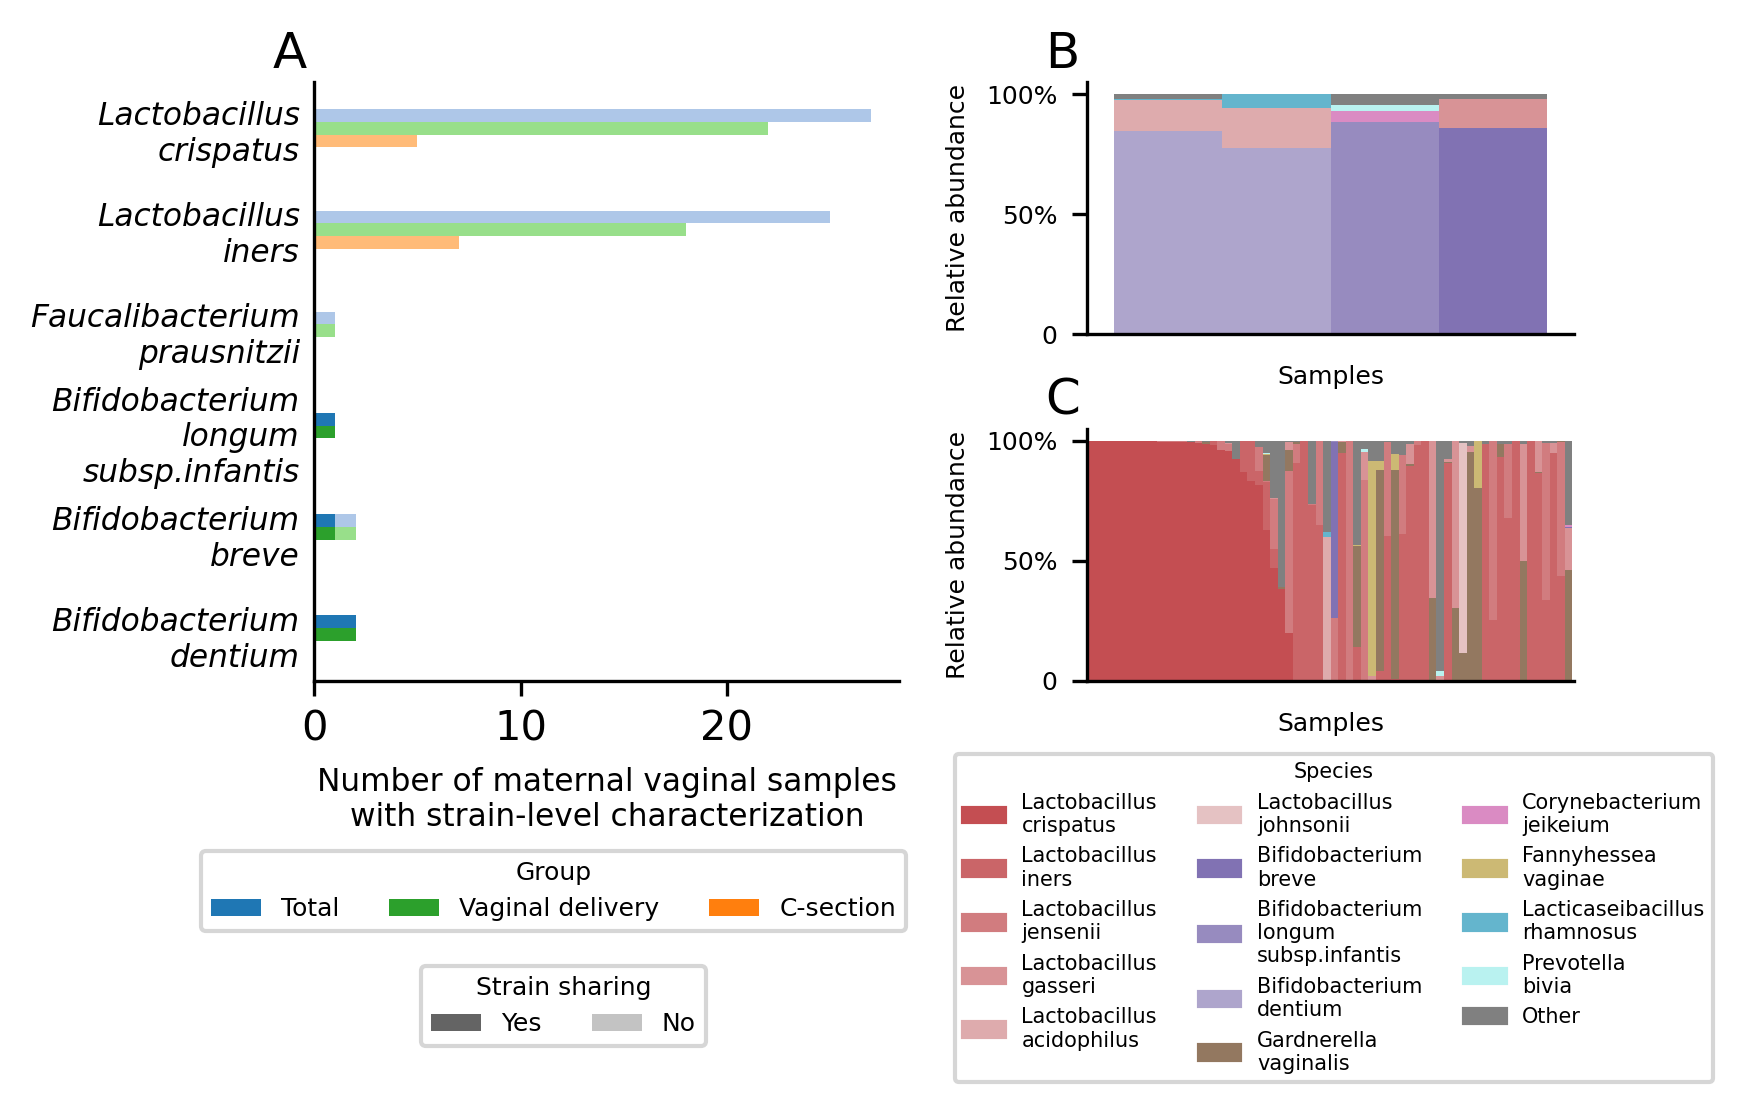

In [104]:
fig_3 = plt.figure(figsize=(6,4), dpi=300)
gs_fig_3 = gridspec.GridSpec(3, 2, figure=fig_3, width_ratios=[1.2, 1], height_ratios=[1, 1, 0.25], wspace=0.35, hspace=0.5)
ax1_vaginal_sharing = fig_3.add_subplot(gs_fig_3[0:2, 0])
ax2_vaginal_sharing = fig_3.add_subplot(gs_fig_3[0, 1])
ax3_vaginal_sharing = fig_3.add_subplot(gs_fig_3[1, 1])


# Calculate the height for each individual bar.
bar_height = 0.1 
species_spacing = 0.5 # Space between each main species

# pick up color for group and strain sharing
group_colors = {
    'total': ('#1f77b4', '#aec7e8'), # Darker and Lighter Blue (strain sharing, no strain sharing)
    'vaginal delivery': ('#2ca02c', '#98df8a'), # Darker and Lighter Green
    'c-section': ('#ff7f0e','#ffbb78')  # Darker and Lighter Orange
}

## genus color
genus_palette = sn.color_palette('deep', 10)
# create taxonomy color map
lactobacillus_colors = sn.light_palette(genus_palette[3], n_colors=8)[2:]
bifido_colors = sn.light_palette(genus_palette[4], n_colors=6)[2:]

tax_color_map = {}
tax_color_map.update(dict(zip(['Lactobacillus\ncrispatus',
                               'Lactobacillus\niners',
                               'Lactobacillus\njensenii',
                               'Lactobacillus\ngasseri',
                               'Lactobacillus\nacidophilus',
                               'Lactobacillus\njohnsonii',
                               ], lactobacillus_colors[::-1])))
tax_color_map.update(dict(zip(['Bifidobacterium\nbreve',
                               'Bifidobacterium\nlongum\nsubsp.infantis',
                               'Bifidobacterium\ndentium',
                              ], bifido_colors[::-1])))

tax_color_map['Gardnerella\nvaginalis'] = genus_palette[5]
tax_color_map['Corynebacterium\njeikeium'] = genus_palette[6]
tax_color_map['Fannyhessea\nvaginae'] = genus_palette[8]
tax_color_map['Lacticaseibacillus\nrhamnosus'] = genus_palette[9]
tax_color_map['Prevotella\nbivia'] = sn.color_palette('pastel', 10)[-1]
tax_color_map['Other'] = 'grey'

##strain transmission stacked bar plot
def plot_stacked_bar_chart(ax, df, title, subplot_label):

    # Define the x-axis species and groups from the pivoted DataFrame.
    species_unique = df['species'].unique()
    group_unique = df['group'].unique()

    num_groups = len(group_unique)
    # Calculate positions for each individual bar on the y-ayis.
    # These positions are for the actual bars.
    y_positions = []
    group_center_positions = []
    group_labels_only = []
    for i, y_species in enumerate(species_unique):
        # Calculate the base position for the current main species's first group bar.
        base_pos = i * (bar_height * num_groups + species_spacing)
        for j, group_name in enumerate(group_unique):
            # Position for each subgroup bar within the current species.
            pos = base_pos + j * bar_height
            y_positions.append(pos)
        # Calculate the starting y-position of the first bar in this group's cluster.
        start_of_group_cluster = i * (bar_height * num_groups + species_spacing)
        # Calculate the ending y-position of the last bar in this group's cluster.
        end_of_group_cluster = start_of_group_cluster + (num_groups - 1) * bar_height
        # The center is the average of the start and end positions.
        center_of_group_label = (start_of_group_cluster + end_of_group_cluster) / 2
        group_center_positions.append(center_of_group_label)
        group_labels_only.append(y_species) # Only the group name for the y-axis label

    
    # Prepare lists for component values and their respective colors for all bars
    comp_x_values = []
    comp_y_values = []
    colors_comp_x = []
    colors_comp_y = []

    for i, y_species in enumerate(species_unique):
        for j, group_name in enumerate(group_unique):
            # Retrieve the 'Yes' and 'No' values for the current group and subgroup.
            val_x = df[(df['species'] == y_species) & (df['group'] == group_name)]['Yes'].iloc[0]
            val_y = df[(df['species'] == y_species) & (df['group'] == group_name)]['No'].iloc[0]

            comp_x_values.append(val_x)
            comp_y_values.append(val_y)

            # Append the appropriate shade for Component X and Component Y based on the subgroup.
            colors_comp_x.append(group_colors[group_name][0]) # Darker shade for Component X
            colors_comp_y.append(group_colors[group_name][1]) # Lighter shade for Component Y

    # Plot 'Yes' (the bottom part of the stacked bars)
    # The 'color' argument now takes a list, applying a different color to each bar based on its subgroup.
    ax.barh(y_positions, comp_x_values, bar_height, color=colors_comp_x)

    # Plot 'No' (the top part of the stacked bars)
    # It's stacked on top of Component X, and its colors also vary by subgroup.
    ax.barh(y_positions, comp_y_values, bar_height, left=comp_x_values, color=colors_comp_y)


    # Customize the plot for better readability.
    ax.set_xlabel('Number of maternal vaginal samples\nwith strain-level characterization',
                  fontsize=7.5)

    # Set x-axis ticks to the calculated center positions and apply only group names as labels.
    # ax.set_title(title)
    ax.text(0,1,
            subplot_label,
            transform=(ax.transAxes + ScaledTranslation(-10/72, +1/72, fig_3.dpi_scale_trans)),
            fontsize=12, va='bottom')
    ax.set_yticks(group_center_positions) # No rotation needed if labels are short
    ax.set_yticklabels(group_labels_only, fontstyle='italic', fontsize=7.5)
    ax.tick_params(axis='y', length=0)
    ax.grid(False)


## taxonomy bar plot

def plot_taxonomy_bars(ax, df, title, subplot_label):
    """
    Draws a taxonomy stacked bar plot on a given matplotlib axes.

    Args:
        ax (matplotlib.axes.Axes): The axes to draw the plot on.
        df (pd.DataFrame): The percentage data for the taxonomy plot.
        title (str): The title for the subplot.
    """
    ## mean abundance without 'Other'
    species_mean_rl = df.drop('Other').mean(axis=1).sort_values(ascending=False)
    top_species_name = species_mean_rl.index[0]

    stacking_order = species_mean_rl.index.to_list() + ['Other']
    ## data frame sorted by mean relative eabundance
    df_sorted_tax = df.loc[stacking_order]

    ## sample order
    sample_order = df.loc[top_species_name].sort_values(ascending=False).index

    ## create dataframe for plot
    plot_df = df_sorted_tax[sample_order].T

    plot_colors = [tax_color_map[species] for species in plot_df.columns]
    
    plot_df.plot(kind='bar', stacked=True, color=plot_colors, ax=ax, width=1, legend=False)
    ax.text(0,1,
            subplot_label,
            transform=(ax.transAxes + ScaledTranslation(-10/72, +1/72, fig_3.dpi_scale_trans)),
            fontsize=12, va='bottom')
    # ax.set_title(title, fontsize=10)
    ax.set_xlabel('Samples', fontsize=6)
    ax.set_xticks([])
    ax.set_ylabel('Relative abundance', fontsize=6)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    ax.set_yticklabels(["0","50%","100%"],fontsize=6)
    ax.set_ylim(0, 105)


# plot the transmission distribution
plot_stacked_bar_chart(ax1_vaginal_sharing,
                       strain_vaginal_all_vis_data_pivot,
                       'Strain sharing of maternal vaginal microbiome','A')

# plot taxonomy for the vaginal microbiome for mothers who shared with children
plot_taxonomy_bars(ax2_vaginal_sharing, vaginal_shared_mtp_vis_clean, "Species-level composition of vaginal microbiome\nin mothers who shared strains with children's gut microbiome",'B')
plot_taxonomy_bars(ax3_vaginal_sharing, vaginal_unshared_mtp_vis_clean, "Species-level composition of vaginal microbiomen\nin mothers who didn't share strains with children's gut microbiome",'C')



# Create a custom legend for Subgroups.
legend_elements_group = [
    Patch(facecolor=group_colors['total'][0], label='Total'),
    Patch(facecolor=group_colors['vaginal delivery'][0], label='Vaginal delivery'),
    Patch(facecolor=group_colors['c-section'][0], label='C-section')
]

# Create a custom legend for Stack Components.
legend_elements_strainsharing = [
    Patch(facecolor='#646464', label='Yes'), # Darker shade example
    Patch(facecolor='#c3c3c3', label='No')  # Lighter shade example
]

species_handles = [plt.Rectangle((0,0),1,1, color=tax_color_map[species]) for species in tax_color_map]
species_labels = list(tax_color_map.keys())

leg_ax_vaginal_sharing = fig_3.add_subplot(gs_fig_3[2, :])
leg_ax_vaginal_sharing.axis('off')

## add all legends to legend ax
leg1_vaginal_sharing = leg_ax_vaginal_sharing.legend(handles=legend_elements_group,
                                                     title='Group', loc='upper left',
                                                     bbox_to_anchor=(-0.1, 0),
                                                     ncol=len(legend_elements_group), fontsize=6,
                                                     title_fontsize=6)
leg2_vaginal_sharing = leg_ax_vaginal_sharing.legend(handles=legend_elements_strainsharing,
                                                     title='Strain sharing', loc='lower left',
                                                     bbox_to_anchor=(0.075, -3.5),
                                                     ncol=len(legend_elements_strainsharing), fontsize=6,
                                                     title_fontsize=6)
leg3_vaginal_sharing = leg_ax_vaginal_sharing.legend(handles=species_handles,
                                                     labels=species_labels,
                                                     title='Species',
                                                     loc='upper left',
                                                     bbox_to_anchor=(0.5, 1.5),
                                                     ncol=3, fontsize=5,
                                                     title_fontsize=5)
leg_ax_vaginal_sharing.add_artist(leg1_vaginal_sharing)
leg_ax_vaginal_sharing.add_artist(leg2_vaginal_sharing)

# Clean up final layout
sn.despine()
fig_3.subplots_adjust(bottom=0.25, left=0.2)
plt.show()

fig_3.savefig(f'{final_fig_dir}/fig3.png', dpi=300, bbox_inches='tight')
fig_3.savefig(f'{final_fig_dir}/fig3.pdf', dpi=300, bbox_inches='tight')


### 3.4 Prevalence of Bacteroides or Bifidobacterium at age 2-4 months: Table S7

**presence definition: >= 0.1%**

In [105]:
## microbes of interest: Bacteriodes spp. or Bifidobacterium spp. with any transmission
bacteroides_of_interest = ['s__Bacteroides_fragilis',
                           's__Bacteroides_thetaiotaomicron',
                           's__Bacteroides_uniformis',
                           's__Bacteroides_caccae',
                           's__Bacteroides_stercoris'
                          ]

bifido_of_interest =['s__Bifidobacterium_adolescentis',
                     's__Bifidobacterium_bifidum',
                     's__Bifidobacterium_dentium',
                     's__Bifidobacterium_longum_subsp.longum',
                     's__Bifidobacterium_pseudocatenulatum',
                     's__Bifidobacterium_longum_subsp.infantis',
                     's__Bifidobacterium_breve']

#### 3.4.1 Prevalence of Bacteroides and Bifidobacterium in maternal samples

In [106]:
## calculate the prevalence of any Bacteroides/any Bifidobacterium

cxsectional_parent_fecal_all_bacteroides_sum = (mtp_species_parent_fecal[
    mtp_species_parent_fecal.columns[mtp_species_parent_fecal.columns.map(lambda x: 'Bacteroides' in x)]
].sum(axis=1) >= 0.001).sum()

cxsectional_parent_vaginal_all_bacteroides_sum = (mtp_species_parent_vaginal[
    mtp_species_parent_vaginal.columns[mtp_species_parent_vaginal.columns.map(lambda x: 'Bacteroides' in x)]
].sum(axis=1) >= 0.001).sum()

cxsectional_parent_fecal_all_bifido_sum = (mtp_species_parent_fecal[
    mtp_species_parent_fecal.columns[mtp_species_parent_fecal.columns.map(lambda x: 'Bifidobacterium' in x)]
].sum(axis=1) >= 0.001).sum()

cxsectional_parent_vaginal_all_bifido_sum = (mtp_species_parent_vaginal[
    mtp_species_parent_vaginal.columns[mtp_species_parent_vaginal.columns.map(lambda x: 'Bifidobacterium' in x)]
].sum(axis=1) >= 0.001).sum()


In [107]:
## calculate the prevalence of microbes of interest

cxsectional_parent_fecal_bacteroides_sum = (mtp_species_parent_fecal[bacteroides_of_interest] >= 0.001).sum()
cxsectional_parent_vaginal_bacteroides_sum = (mtp_species_parent_vaginal[bacteroides_of_interest] >= 0.001).sum()
cxsectional_parent_fecal_bifido_sum = (mtp_species_parent_fecal[bifido_of_interest] >= 0.001).sum()
cxsectional_parent_vaginal_bifido_sum = (mtp_species_parent_vaginal[bifido_of_interest] >= 0.001).sum()

In [108]:
## present the results:
## Prevalence of Bacteroides in maternal gut/vaginal microbiome

maternal_bacteroides_prevalence_result = \
    pd.concat([
        cxsectional_parent_fecal_bacteroides_sum.astype(str) + \
            ' (' + \
        (cxsectional_parent_fecal_bacteroides_sum*100/mtp_species_parent_fecal.shape[0]).map(lambda x: f"{x:.1f}") + \
            ')',
        cxsectional_parent_vaginal_bacteroides_sum.astype(str) + \
            ' (' + \
        (cxsectional_parent_vaginal_bacteroides_sum*100/mtp_species_parent_vaginal.shape[0]).map(lambda x: f"{x:.1f}") + \
            ')'
    ], axis=1)


maternal_bacteroides_prevalence_result.loc["All Bacteroides"] = \
    [f"{cxsectional_parent_fecal_all_bacteroides_sum} ({cxsectional_parent_fecal_all_bacteroides_sum*100/mtp_species_parent_fecal.shape[0]: .1f})",
     f"{cxsectional_parent_vaginal_all_bacteroides_sum} ({cxsectional_parent_vaginal_all_bacteroides_sum*100/mtp_species_parent_vaginal.shape[0]: .1f})"]

maternal_bacteroides_prevalence_result.rename(columns={0: 'Maternal gut (n=68)',
                                                       1: 'Maternal vaginal (n=68)'},
                                              inplace=True)

maternal_bacteroides_prevalence_result

,Maternal gut (n=68),Maternal vaginal (n=68)
s__Bacteroides_fragilis,18 (26.5),0 (0.0)
s__Bacteroides_thetaiotaomicron,27 (39.7),1 (1.5)
s__Bacteroides_uniformis,54 (79.4),1 (1.5)
s__Bacteroides_caccae,23 (33.8),0 (0.0)
s__Bacteroides_stercoris,28 (41.2),0 (0.0)
All Bacteroides,64 ( 94.1),1 ( 1.5)


In [109]:
## present the results:
## Prevalence of Bifidobacterium in maternal gut/vaginal microbiome

maternal_bifido_prevalence_result = \
    pd.concat([
        cxsectional_parent_fecal_bifido_sum.astype(str) + \
            ' (' + \
        (cxsectional_parent_fecal_bifido_sum*100/mtp_species_parent_fecal.shape[0]).map(lambda x: f"{x:.1f}") + \
            ')',
        cxsectional_parent_vaginal_bifido_sum.astype(str) + \
            ' (' + \
        (cxsectional_parent_vaginal_bifido_sum*100/mtp_species_parent_vaginal.shape[0]).map(lambda x: f"{x:.1f}") + \
            ')'
    ], axis=1)


maternal_bifido_prevalence_result.loc["All Bifidobacterium"] = \
    [f"{cxsectional_parent_fecal_all_bifido_sum} ({cxsectional_parent_fecal_all_bifido_sum*100/mtp_species_parent_fecal.shape[0]: .1f})",
     f"{cxsectional_parent_vaginal_all_bifido_sum} ({cxsectional_parent_vaginal_all_bifido_sum*100/mtp_species_parent_vaginal.shape[0]: .1f})"]

maternal_bifido_prevalence_result.rename(columns={0: 'Maternal gut (n=68)',
                                                  1: 'Maternal vaginal (n=68)'},
                                         inplace=True)

maternal_bifido_prevalence_result

,Maternal gut (n=68),Maternal vaginal (n=68)
s__Bifidobacterium_adolescentis,44 (64.7),1 (1.5)
s__Bifidobacterium_bifidum,15 (22.1),1 (1.5)
s__Bifidobacterium_dentium,1 (1.5),2 (2.9)
s__Bifidobacterium_longum_subsp.longum,42 (61.8),7 (10.3)
s__Bifidobacterium_pseudocatenulatum,13 (19.1),0 (0.0)
s__Bifidobacterium_longum_subsp.infantis,0 (0.0),2 (2.9)
s__Bifidobacterium_breve,0 (0.0),3 (4.4)
All Bifidobacterium,59 ( 86.8),11 ( 16.2)


#### 3.4.2 Prevalence of Bacteroides and Bifidobacterium in infant sample (month 2-4)

In [110]:
## cross-sectional infant SGB table at month 2-4

mtp_species_blongum_breakdown_cxsectional_kid = \
    mtp_species_blongum_breakdown.loc[included_cxsection_manifest_kid.index].copy()

In [111]:
## the presence/absence data in microbes: month 2-4

### all Bacteroides
cxsectional_kid_fecal_all_bacteroides_q = (
    mtp_species_blongum_breakdown_cxsectional_kid[
        mtp_species_blongum_breakdown_cxsectional_kid.columns[
            mtp_species_blongum_breakdown_cxsectional_kid.columns.map(lambda x: 'Bacteroides' in x)
        ]
    ].sum(axis=1) >= 0.001
)

### all Bifidobacterium
cxsectional_kid_fecal_all_bifido_q = (
    mtp_species_blongum_breakdown_cxsectional_kid[
        mtp_species_blongum_breakdown_cxsectional_kid.columns[
            mtp_species_blongum_breakdown_cxsectional_kid.columns.map(lambda x: 'Bifidobacterium' in x)
        ]
    ].sum(axis=1) >= 0.001
)

### Bacteroides of interest
cxsectional_kid_fecal_bacteroides_q = (
    mtp_species_blongum_breakdown_cxsectional_kid[
        bacteroides_of_interest
    ] >= 0.001
)

### Bifidobacterium of interest
cxsectional_kid_fecal_bifido_q = (
    mtp_species_blongum_breakdown_cxsectional_kid[
        bifido_of_interest
    ] >= 0.001
)

In [112]:
## calculate the prevalence of any Bacteroides
cxsectional_kid_fecal_all_bacteroides_sum = cxsectional_kid_fecal_all_bacteroides_q.sum()

## calculate the prevalence of any Bifidobacterium
cxsectional_kid_fecal_all_bifido_sum = cxsectional_kid_fecal_all_bifido_q.sum()

## calculate the prevalence of Bacteroides of interest
cxsectional_kid_fecal_bacteroides_sum = cxsectional_kid_fecal_bacteroides_q.sum()

## calculate the prevalence of Bifidobacterium of interest
cxsectional_kid_fecal_bifido_sum = cxsectional_kid_fecal_bifido_q.sum()


In [113]:
## present the results:
## Prevalence of Bacteroides in infant gut microbiome: 2-4 months

kid_bacteroides_prevalence_result = \
    (cxsectional_kid_fecal_bacteroides_sum.astype(str) + \
         ' (' + \
     (cxsectional_kid_fecal_bacteroides_sum*100/mtp_species_blongum_breakdown_cxsectional_kid.shape[0]).map(lambda x: f"{x:.1f}") + \
         ')'
    ).to_frame()

kid_bacteroides_prevalence_result.loc["All Bacteroides"] = \
    f"{cxsectional_kid_fecal_all_bacteroides_sum} ({cxsectional_kid_fecal_all_bacteroides_sum*100/mtp_species_blongum_breakdown_cxsectional_kid.shape[0]: .1f})"

kid_bacteroides_prevalence_result.rename(columns={0: 'Infant gut (n=68)'},
                                         inplace=True)

kid_bacteroides_prevalence_result

,Infant gut (n=68)
s__Bacteroides_fragilis,14 (20.6)
s__Bacteroides_thetaiotaomicron,16 (23.5)
s__Bacteroides_uniformis,18 (26.5)
s__Bacteroides_caccae,8 (11.8)
s__Bacteroides_stercoris,7 (10.3)
All Bacteroides,35 ( 51.5)


#### 3.4.3 Prevalence of Bacteroides and Bifidobacterium in infant sample by delivery mode (month 2-4)

In [114]:
## present the results:
## Prevalence of Bifidobacterium in infant gut microbiome: 2-4 months

kid_bifido_prevalence_result = \
    (cxsectional_kid_fecal_bifido_sum.astype(str) + \
         ' (' + \
     (cxsectional_kid_fecal_bifido_sum*100/mtp_species_blongum_breakdown_cxsectional_kid.shape[0]).map(lambda x: f"{x:.1f}") + \
         ')'
    ).to_frame()

kid_bifido_prevalence_result.loc["All Bifidobacterium"] = \
    f"{cxsectional_kid_fecal_all_bifido_sum} ({cxsectional_kid_fecal_all_bifido_sum*100/mtp_species_blongum_breakdown_cxsectional_kid.shape[0]: .1f})"

kid_bifido_prevalence_result.rename(columns={0: 'Infant gut (n=68)'},
                                    inplace=True)

kid_bifido_prevalence_result

,Infant gut (n=68)
s__Bifidobacterium_adolescentis,6 (8.8)
s__Bifidobacterium_bifidum,20 (29.4)
s__Bifidobacterium_dentium,6 (8.8)
s__Bifidobacterium_longum_subsp.longum,53 (77.9)
s__Bifidobacterium_pseudocatenulatum,13 (19.1)
s__Bifidobacterium_longum_subsp.infantis,8 (11.8)
s__Bifidobacterium_breve,31 (45.6)
All Bifidobacterium,58 ( 85.3)


#### 3.4.3 Prevalence of Bacteroides in infant sample (month 2-4): by delivery mode, prenatal antibiotics and exclusive breastfeeding

In [115]:
## get the metadata for infant: month 2-4

mapping_tab_kid= mapping_tab.loc[mtp_species_blongum_breakdown_cxsectional_kid.index]

mapping_tab_kid['birth_delivm'] = \
   mapping_tab_kid['birth_delivm'].replace({'1': 'Vaginal delivery',
                                            '2': 'C-section'}) 

mapping_tab_kid['med_antib_pn'] = \
   mapping_tab_kid['med_antib_pn'].replace({'1': 'Prenatal Abx',
                                            '0': 'No Prenatal Abx'}) 

mapping_tab_kid['exclusive_breastfed'] = \
   mapping_tab_kid['exclusive_breastfed'].replace({'1': 'Exclusive Breastfed',
                                                   '0': 'No Exclusive Breastfed',
                                                   '-9': np.nan}) 

In [116]:
def prev_by_meta(presence_data,
                 microbe,
                 meta_var,
                 mapping_tab=mapping_tab_kid):
    """
    Get the prevalence of specified microbes by metadata
    """
    ### subset non-missing mapping tab
    mapping_tab_nomissing = mapping_tab.dropna(subset=meta_var)

    ### subset presence_data with complete metadata
    presence_data_complete = presence_data.loc[mapping_tab_nomissing.index]

    ### get the presence series based on microbes
    if microbe in ["All Bifidobacterium", "All Bacteroides"]:
        presence_series = presence_data_complete
    else:
        presence_series = presence_data_complete[microbe]

    ### get cross tab: microbes presence by metadata (n, freq)
    temp_crosstab = pd.crosstab(mapping_tab_nomissing[meta_var],
                                presence_series)

    temp_crosstab_p = pd.crosstab(mapping_tab_nomissing[meta_var],
                                  presence_series, normalize='index')

    ### combine n with frequency
    temp_crosstab_print = temp_crosstab[True].astype(str) + '(' + temp_crosstab_p[True].map(lambda x: f"{x*100:.1f}") + ')'

    ### output as dataframe
    temp_crosstab_print_tab = temp_crosstab_print.to_frame().T

    ### calculate fisher exact test p
    temp_exact_fisher_p = scipy.stats.fisher_exact(temp_crosstab)[1]
    
    temp_crosstab_print_tab['fisher_exact_p'] = \
        "< 0.001" if temp_exact_fisher_p < 0.001 else f"{temp_exact_fisher_p:.3f}"
    
    temp_crosstab_print_tab.rename(index={True: microbe}, inplace=True)

    return temp_crosstab_print_tab


In [117]:
## Prevalence of Bacteroides in infant fecal microbiome by delivery mode: month 2-4

bacteroides_prev_by_delivm = []
bacteroides_prev_by_delivm.append(
    prev_by_meta(cxsectional_kid_fecal_all_bacteroides_q,
                 'All Bacteroides',
                 'birth_delivm')
)

for microbe in bacteroides_of_interest:
    bacteroides_prev_by_delivm.append(
        prev_by_meta(cxsectional_kid_fecal_bacteroides_q,
                     microbe,
                     'birth_delivm')
    )

bacteroides_prev_by_delivm_df = pd.concat(bacteroides_prev_by_delivm, axis=0)
bacteroides_prev_by_delivm_df

birth_delivm,C-section,Vaginal delivery,fisher_exact_p
All Bacteroides,1(6.7),34(64.2),< 0.001
s__Bacteroides_fragilis,1(6.7),13(24.5),0.167
s__Bacteroides_thetaiotaomicron,0(0.0),16(30.2),0.015
s__Bacteroides_uniformis,1(6.7),17(32.1),0.055
s__Bacteroides_caccae,0(0.0),8(15.1),0.184
s__Bacteroides_stercoris,1(6.7),6(11.3),1.000


In [118]:
## Prevalence of Bacteroides in infant fecal microbiome by prenatal antibiotics use: month 2-4

bacteroides_prev_by_preabx = []
bacteroides_prev_by_preabx.append(
    prev_by_meta(cxsectional_kid_fecal_all_bacteroides_q,
                 'All Bacteroides',
                 'med_antib_pn')
)

for microbe in bacteroides_of_interest:
    bacteroides_prev_by_preabx.append(
        prev_by_meta(cxsectional_kid_fecal_bacteroides_q,
                     microbe,
                     'med_antib_pn')
    )

bacteroides_prev_by_preabx_df = pd.concat(bacteroides_prev_by_preabx, axis=0)
bacteroides_prev_by_preabx_df

med_antib_pn,No Prenatal Abx,Prenatal Abx,fisher_exact_p
All Bacteroides,16(44.4),19(59.4),0.236
s__Bacteroides_fragilis,9(25.0),5(15.6),0.383
s__Bacteroides_thetaiotaomicron,8(22.2),8(25.0),1.000
s__Bacteroides_uniformis,6(16.7),12(37.5),0.061
s__Bacteroides_caccae,2(5.6),6(18.8),0.135
s__Bacteroides_stercoris,3(8.3),4(12.5),0.699


In [119]:
## Prevalence of Bacteroides in infant fecal microbiome by exclusive breastfeeding: month 2-4

bacteroides_prev_by_breastfed = []
bacteroides_prev_by_breastfed.append(
    prev_by_meta(cxsectional_kid_fecal_all_bacteroides_q,
                 'All Bacteroides',
                 'exclusive_breastfed')
)

for microbe in bacteroides_of_interest:
    bacteroides_prev_by_breastfed.append(
        prev_by_meta(cxsectional_kid_fecal_bacteroides_q,
                     microbe,
                     'exclusive_breastfed')
    )

bacteroides_prev_by_breastfed_df = pd.concat(bacteroides_prev_by_breastfed, axis=0)
bacteroides_prev_by_breastfed_df

exclusive_breastfed,Exclusive Breastfed,No Exclusive Breastfed,fisher_exact_p
All Bacteroides,18(45.0),15(78.9),0.024
s__Bacteroides_fragilis,9(22.5),5(26.3),0.753
s__Bacteroides_thetaiotaomicron,6(15.0),9(47.4),0.012
s__Bacteroides_uniformis,8(20.0),9(47.4),0.062
s__Bacteroides_caccae,3(7.5),5(26.3),0.097
s__Bacteroides_stercoris,2(5.0),5(26.3),0.030


#### 3.4.4 Prevalence of Bifidobacterium in infant sample (month 2-4): by delivery mode, prenatal antibiotics and exclusive breastfeeding

In [120]:
## Prevalence of Bifidobacterium in infant fecal microbiome by delivery mode: month 2-4

bifido_prev_by_delivm = []
bifido_prev_by_delivm.append(
    prev_by_meta(cxsectional_kid_fecal_all_bifido_q,
                 'All Bifidobacterium',
                 'birth_delivm')
)

for microbe in bifido_of_interest:
    bifido_prev_by_delivm.append(
        prev_by_meta(cxsectional_kid_fecal_bifido_q,
                     microbe,
                     'birth_delivm')
    )

bifido_prev_by_delivm_df = pd.concat(bifido_prev_by_delivm, axis=0)
bifido_prev_by_delivm_df

birth_delivm,C-section,Vaginal delivery,fisher_exact_p
All Bifidobacterium,13(86.7),45(84.9),1.000
s__Bifidobacterium_adolescentis,0(0.0),6(11.3),0.326
s__Bifidobacterium_bifidum,1(6.7),19(35.8),0.051
s__Bifidobacterium_dentium,1(6.7),5(9.4),1.000
s__Bifidobacterium_longum_subsp.longum,13(86.7),40(75.5),0.492
s__Bifidobacterium_pseudocatenulatum,1(6.7),12(22.6),0.269
s__Bifidobacterium_longum_subsp.infantis,2(13.3),6(11.3),1.000
s__Bifidobacterium_breve,7(46.7),24(45.3),1.000


In [121]:
## Prevalence of Bifidobacterium in infant fecal microbiome by prenatal antibiotics use: month 2-4

bifido_prev_by_preabx = []
bifido_prev_by_preabx.append(
    prev_by_meta(cxsectional_kid_fecal_all_bifido_q,
                 'All Bifidobacterium',
                 'med_antib_pn')
)

for microbe in bifido_of_interest:
    bifido_prev_by_preabx.append(
        prev_by_meta(cxsectional_kid_fecal_bifido_q,
                     microbe,
                     'med_antib_pn')
    )

bifido_prev_by_preabx_df = pd.concat(bifido_prev_by_preabx, axis=0)
bifido_prev_by_preabx_df

med_antib_pn,No Prenatal Abx,Prenatal Abx,fisher_exact_p
All Bifidobacterium,27(75.0),31(96.9),0.015
s__Bifidobacterium_adolescentis,2(5.6),4(12.5),0.410
s__Bifidobacterium_bifidum,9(25.0),11(34.4),0.435
s__Bifidobacterium_dentium,5(13.9),1(3.1),0.203
s__Bifidobacterium_longum_subsp.longum,22(61.1),31(96.9),< 0.001
s__Bifidobacterium_pseudocatenulatum,6(16.7),7(21.9),0.759
s__Bifidobacterium_longum_subsp.infantis,2(5.6),6(18.8),0.135
s__Bifidobacterium_breve,12(33.3),19(59.4),0.050


In [122]:
## Prevalence of Bifidobacterium in infant fecal microbiome by exclusive breastfeeding: month 2-4

bifido_prev_by_breastfed = []
bifido_prev_by_breastfed.append(
    prev_by_meta(cxsectional_kid_fecal_all_bifido_q,
                 'All Bifidobacterium',
                 'exclusive_breastfed')
)

for microbe in bifido_of_interest:
    bifido_prev_by_breastfed.append(
        prev_by_meta(cxsectional_kid_fecal_bifido_q,
                     microbe,
                     'exclusive_breastfed')
    )

bifido_prev_by_breastfed_df = pd.concat(bifido_prev_by_breastfed, axis=0)
bifido_prev_by_breastfed_df

exclusive_breastfed,Exclusive Breastfed,No Exclusive Breastfed,fisher_exact_p
All Bifidobacterium,32(80.0),18(94.7),0.247
s__Bifidobacterium_adolescentis,2(5.0),4(21.1),0.078
s__Bifidobacterium_bifidum,8(20.0),7(36.8),0.207
s__Bifidobacterium_dentium,3(7.5),2(10.5),0.653
s__Bifidobacterium_longum_subsp.longum,27(67.5),18(94.7),0.024
s__Bifidobacterium_pseudocatenulatum,7(17.5),4(21.1),0.734
s__Bifidobacterium_longum_subsp.infantis,6(15.0),1(5.3),0.411
s__Bifidobacterium_breve,16(40.0),10(52.6),0.410


### 3.5: B.infantis to B.longum ratio in infant gut microbiome by breastfeeding and delivery mode (month 2-4): Figure 4

In [123]:
infantis_longum_metadata_df = pd.merge(mtp_species_blongum_breakdown_cxsectional_kid[
                                           ['s__Bifidobacterium_longum_subsp.infantis',
                                            's__Bifidobacterium_longum_subsp.longum'
                                           ]
                                       ],
                                      mapping_tab_kid.dropna(subset='exclusive_breastfed'),
                                      left_index=True,
                                      right_index=True,
                                      how='inner')

In [124]:
## calculate the infantis to longum ratio

### impute the infantis, longum relative abundance with half of the non-zero minimum values
infantis_longum_metadata_df['infantis_impute'] = \
    infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis'].map(
        lambda x: x if x != 0 else  min(infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis']
                                            [infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis'] != 0]
                                       )/2
    )

infantis_longum_metadata_df['longum_impute'] = \
    infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum'].map(
        lambda x: x if x != 0 else  min(infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum']
                                            [infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum'] != 0]
                                       )/2
    )

# ### sensitivity analysis: impute the infantis, longum relative abundance with half of the non-zero minimum values of infantis
# infantis_longum_metadata_df['infantis_impute'] = \
#     infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis'].map(
#         lambda x: x if x != 0 else  min(infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis']
#                                             [infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis'] != 0]
#                                        )/2
#     )

# infantis_longum_metadata_df['longum_impute'] = \
#     infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis'].map(
#         lambda x: x if x != 0 else  min(infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis']
#                                             [infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis'] != 0]
#                                        )/2
#     )

# ### sensitivity analysis: impute the infantis, longum relative abundance with half of the non-zero minimum values of longum
# infantis_longum_metadata_df['infantis_impute'] = \
#     infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum'].map(
#         lambda x: x if x != 0 else  min(infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum']
#                                             [infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum'] != 0]
#                                        )/2
#     )

# infantis_longum_metadata_df['longum_impute'] = \
#     infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum'].map(
#         lambda x: x if x != 0 else  min(infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum']
#                                             [infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum'] != 0]
#                                        )/2
#     )

# ### sensitivity analysis: impute the infantis, longum relative abundance with 1e-6
# infantis_longum_metadata_df['infantis_impute'] = \
#     infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.infantis'].map(
#         lambda x: x if x != 0 else 1e-6
#     )

# infantis_longum_metadata_df['longum_impute'] = \
#     infantis_longum_metadata_df['s__Bifidobacterium_longum_subsp.longum'].map(
#         lambda x: x if x != 0 else 1e-6
#     )

### calculate infantis to longum ratio based on imputed values
infantis_longum_metadata_df['infantis_longum'] = \
    infantis_longum_metadata_df['infantis_impute']/infantis_longum_metadata_df['longum_impute']

infantis_longum_metadata_df['infantis_longum_log10'] = \
    np.log10(infantis_longum_metadata_df['infantis_longum'])

In [125]:
infantis_longum_bybreastfed_dict = \
    {'overall test p': scipy.stats.mannwhitneyu(
                            infantis_longum_metadata_df.loc[infantis_longum_metadata_df['exclusive_breastfed'] == 'Exclusive Breastfed']['infantis_longum'],
                            infantis_longum_metadata_df.loc[infantis_longum_metadata_df['exclusive_breastfed'] == 'No Exclusive Breastfed']['infantis_longum']
                        )[1],
     'Among vaginal delivery test p': scipy.stats.mannwhitneyu(
                                            infantis_longum_metadata_df.loc[(infantis_longum_metadata_df['exclusive_breastfed'] == 'Exclusive Breastfed') &
                                                                            (infantis_longum_metadata_df['birth_delivm'] == 'Vaginal delivery')
                                                                           ]['infantis_longum'],
                                            infantis_longum_metadata_df.loc[(infantis_longum_metadata_df['exclusive_breastfed'] == 'No Exclusive Breastfed') &
                                                                            (infantis_longum_metadata_df['birth_delivm'] == 'Vaginal delivery')
                                                                           ]['infantis_longum']
                                      )[1],
     'Among C-section test p': scipy.stats.mannwhitneyu(
                                            infantis_longum_metadata_df.loc[(infantis_longum_metadata_df['exclusive_breastfed'] == 'Exclusive Breastfed') &
                                                                            (infantis_longum_metadata_df['birth_delivm'] == 'C-section')
                                                                           ]['infantis_longum'],
                                            infantis_longum_metadata_df.loc[(infantis_longum_metadata_df['exclusive_breastfed'] == 'No Exclusive Breastfed') &
                                                                            (infantis_longum_metadata_df['birth_delivm'] == 'C-section')
                                                                           ]['infantis_longum']
                                      )[1],
     'Among prenatal abx use test p': scipy.stats.mannwhitneyu(
                                            infantis_longum_metadata_df.loc[(infantis_longum_metadata_df['exclusive_breastfed'] == 'Exclusive Breastfed') &
                                                                            (infantis_longum_metadata_df['med_antib_pn'] == 'Prenatal Abx')
                                                                           ]['infantis_longum'],
                                            infantis_longum_metadata_df.loc[(infantis_longum_metadata_df['exclusive_breastfed'] == 'No Exclusive Breastfed') &
                                                                            (infantis_longum_metadata_df['med_antib_pn'] == 'Prenatal Abx')
                                                                           ]['infantis_longum']
                                      )[1],
     'Among no prenatal abx use test p': scipy.stats.mannwhitneyu(
                                            infantis_longum_metadata_df.loc[(infantis_longum_metadata_df['exclusive_breastfed'] == 'Exclusive Breastfed') &
                                                                            (infantis_longum_metadata_df['med_antib_pn'] == 'No Prenatal Abx')
                                                                           ]['infantis_longum'],
                                            infantis_longum_metadata_df.loc[(infantis_longum_metadata_df['exclusive_breastfed'] == 'No Exclusive Breastfed') &
                                                                            (infantis_longum_metadata_df['med_antib_pn'] == 'No Prenatal Abx')
                                                                           ]['infantis_longum']
                                      )[1]
    }

infantis_longum_bybreastfed_df = pd.DataFrame([infantis_longum_bybreastfed_dict]).T
infantis_longum_bybreastfed_df[0] = \
    infantis_longum_bybreastfed_df[0].map(lambda x: f"{x:.3f}")

infantis_longum_bybreastfed_df.rename(columns={0: 'Mann-Whitney U'}, inplace=True)

infantis_longum_bybreastfed_df

,Mann-Whitney U
overall test p,0.031
Among vaginal delivery test p,0.009
Among C-section test p,0.757
Among prenatal abx use test p,0.443
Among no prenatal abx use test p,0.107


In [126]:
infantis_longum_bybreastfed_df.loc['Among vaginal delivery test p'][0]

'0.009'

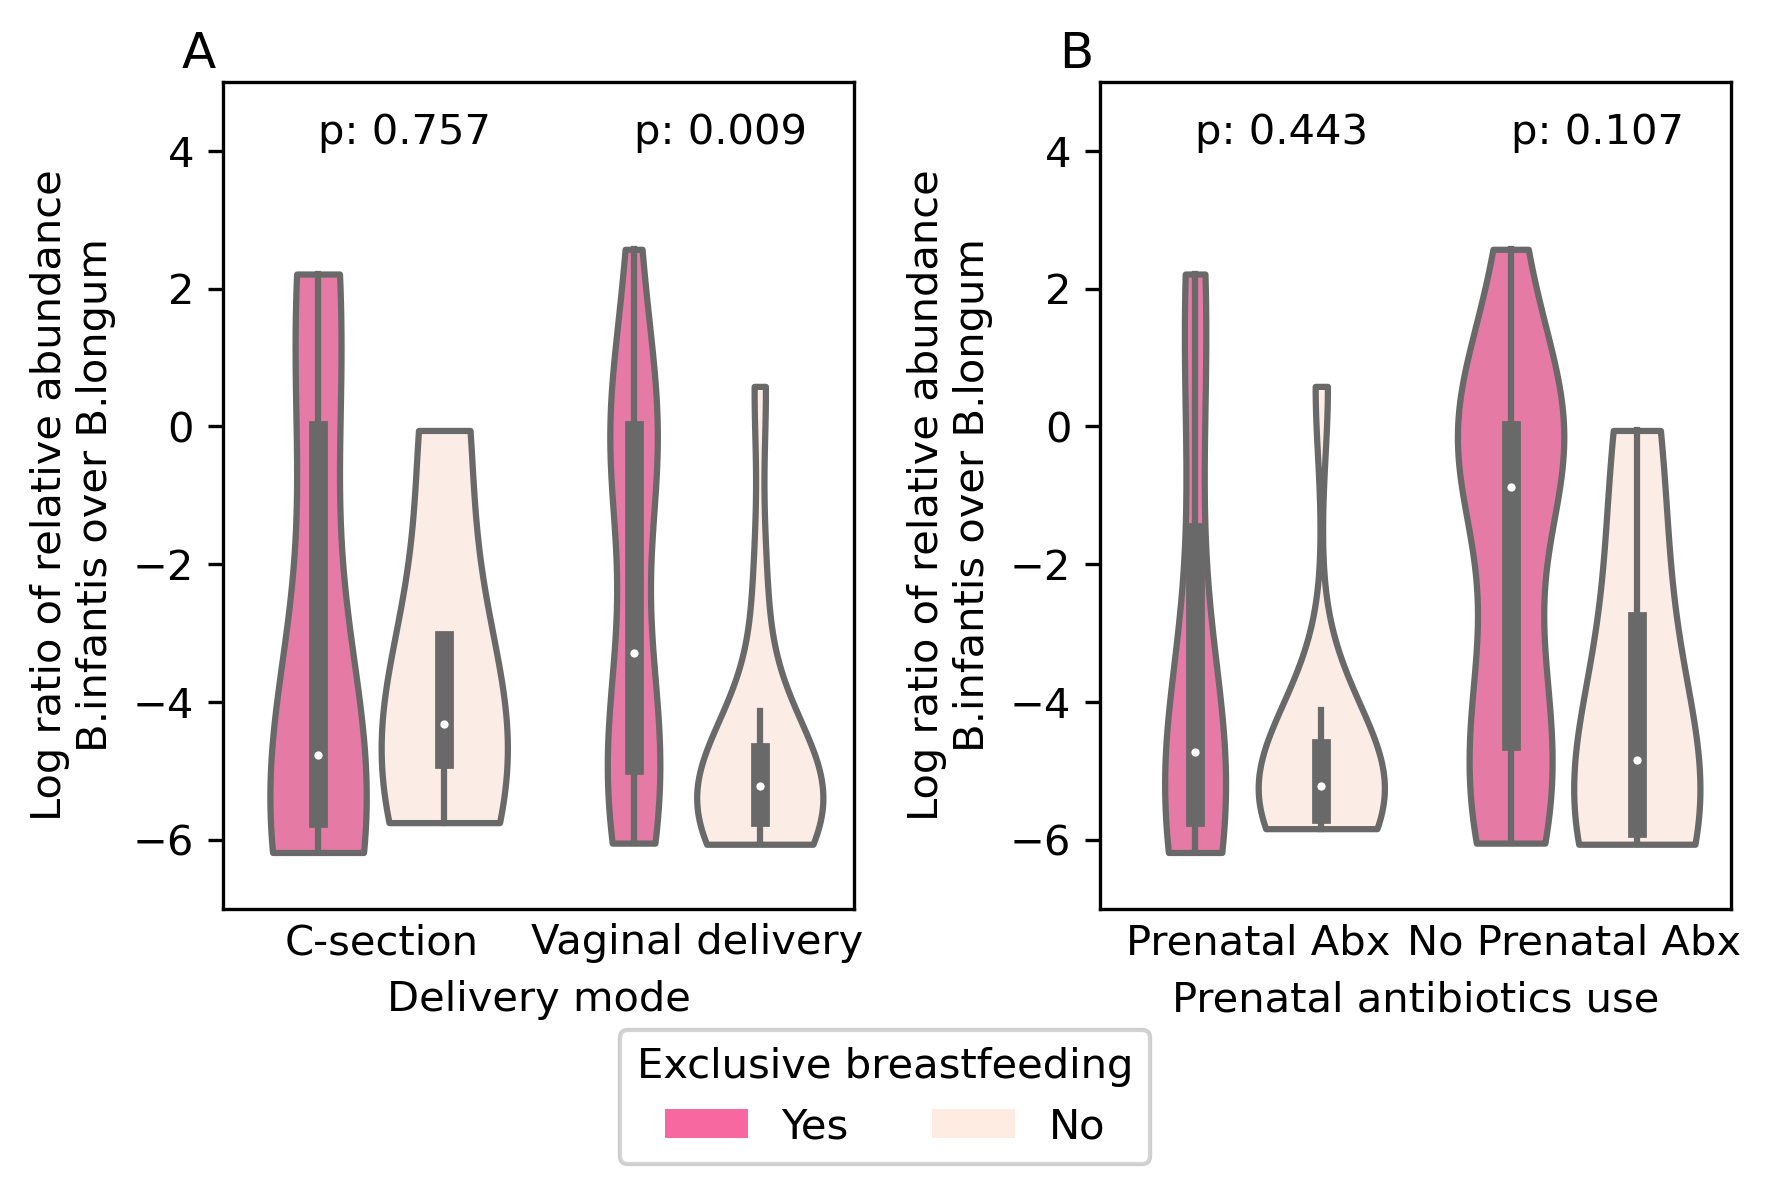

In [127]:
fig_4, axes_fig_4 = plt.subplots(1, 2, figsize=(6, 4), dpi=300)  # 1 row, 2 columns

infantis_longum_bf_deliv_vis = \
    sn.violinplot(x='birth_delivm',
                  y="infantis_longum_log10",
                  hue="exclusive_breastfed",
                  ax=axes_fig_4[0],
                  palette={'Exclusive Breastfed': '#f768a1',
                           'No Exclusive Breastfed': '#feebe2'
                          },
                  data=infantis_longum_metadata_df,
                  cut=0,
                  inner='box',
                  s=0.5,
                  dodge=True, width=0.8, split=False)

infantis_longum_bf_deliv_vis.set(ylabel="Log ratio of relative abundance\nB.infantis over B.longum", xlabel="Delivery mode")
# infantis_longum_bf_deliv_vis.set_xticks(np.arange(0,2,1), labels=['C-section', 'Vaginal delivery'])
infantis_longum_bf_deliv_vis.tick_params(axis='x', length=0)
infantis_longum_bf_deliv_vis.get_legend().remove()
infantis_longum_bf_deliv_vis.set_ylim([-7, 5])
infantis_longum_bf_deliv_vis.text(0.15,0.925,f"p: {infantis_longum_bybreastfed_df.loc['Among C-section test p'][0]}", transform=infantis_longum_bf_deliv_vis.transAxes)
infantis_longum_bf_deliv_vis.text(0.65,0.925,f"p: {infantis_longum_bybreastfed_df.loc['Among vaginal delivery test p'][0]}", transform=infantis_longum_bf_deliv_vis.transAxes)
infantis_longum_bf_deliv_vis.text(0,1,
                                  'A',
                                  transform=(infantis_longum_bf_deliv_vis.transAxes + ScaledTranslation(-10/72, +1/72, fig_4.dpi_scale_trans)),
                                  fontsize=12, va='bottom')

infantis_longum_bf_abx_vis = \
    sn.violinplot(x='med_antib_pn',
                  y="infantis_longum_log10",
                  hue="exclusive_breastfed",
                  ax=axes_fig_4[1],
                  palette={'Exclusive Breastfed': '#f768a1',
                           'No Exclusive Breastfed': '#feebe2'
                          },
                  data=infantis_longum_metadata_df,
                  cut=0,
                  inner='box',
                  dodge=True, width=0.8, split=False)

infantis_longum_bf_abx_vis.set(ylabel="Log ratio of relative abundance\nB.infantis over B.longum", xlabel="Prenatal antibiotics use")
# infantis_longum_bf_abx_vis.set_xticks(np.arange(0,2,1), labels=['Yes', 'No'])
infantis_longum_bf_abx_vis.tick_params(axis='x', length=0)
infantis_longum_bf_abx_vis.get_legend().remove()
infantis_longum_bf_abx_vis.set_ylim([-7, 5])
infantis_longum_bf_abx_vis.text(0.15,0.925,f"p: {infantis_longum_bybreastfed_df.loc['Among prenatal abx use test p'][0]}", transform=infantis_longum_bf_abx_vis.transAxes)
infantis_longum_bf_abx_vis.text(0.65,0.925,f"p: {infantis_longum_bybreastfed_df.loc['Among no prenatal abx use test p'][0]}", transform=infantis_longum_bf_abx_vis.transAxes)
infantis_longum_bf_abx_vis.text(0,1,
                                'B',
                                transform=(infantis_longum_bf_abx_vis.transAxes + ScaledTranslation(-10/72, +1/72, fig_4.dpi_scale_trans)),
                                fontsize=12, va='bottom')

# Create a custom legend for exclusive breastfeeding
legend_elements_exclusivebf = [
    Patch(facecolor='#f768a1', label='Yes'),
    Patch(facecolor='#feebe2', label='No')
]

# Add two separate legends at the bottom for the entire figure
# Adjust bbox_to_anchor for fine-tuning position of each legend
# The first legend (Subgroup)
legend_exclusivebf = fig_4.legend(
                        handles=legend_elements_exclusivebf,
                        loc='lower center', bbox_to_anchor=(0.5, 0), # Position it to the left
                        ncol=len(legend_elements_exclusivebf),
                        title='Exclusive breastfeeding'
)

# Ensure both legends are added to the figure.
# This line is crucial when adding multiple legends to a figure,
# as `fig.legend` typically replaces previous legends.
plt.gca().add_artist(legend_exclusivebf)


plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust tight_layout to make space for the bottom legends


plt.show()
fig_4.savefig(f'{final_fig_dir}/fig4.png', dpi=300, bbox_inches='tight')
fig_4.savefig(f'{final_fig_dir}/fig4.pdf', dpi=300, bbox_inches='tight')

### 3.6: Distance between maternal and infant microbiome in cross-sectional comparison (month 2-4) and longitudianl comparison: Figure S2 and Table S4

#### 3.6.1: Distance between maternal and infant microbiome in cross-sectional comparison

In [128]:
distances_pairwise_cxsection = distances_pairwise[
    distances_pairwise.index.map(lambda x: x[0] in (mapping_tab.index) and
                                           x[1] in (mapping_tab.index)
                                )
].copy()

In [129]:
## merge distance data with metadata
distances_meta_cxsection = distances_pairwise_cxsection.index.to_frame().reset_index(drop=True).join(
    mapping_tab.add_suffix('1'), on='sample-id-1').join(
    mapping_tab.add_suffix('2'), on='sample-id-2'
)
distances_meta_cxsection.set_index(['sample-id-1', 'sample-id-2'], inplace=True)

In [130]:
# generate an indicator for same family 
distances_pairwise_cxsection['same-family'] = distances_meta_cxsection['PregID1'] == distances_meta_cxsection['PregID2']

In [131]:
## pairwise distance: mom vaginal vs kid fecal
distances_comp_vaginal_cxsection = \
    distances_pairwise_cxsection[(distances_meta_cxsection['mwgs_spec_type1'].astype(int) +
                                  distances_meta_cxsection['mwgs_spec_type2'].astype(int) == 8) &
                                 (distances_meta_cxsection['mwgs_part_type1'].astype(int) +
                                  distances_meta_cxsection['mwgs_part_type2'].astype(int) == 3)]

In [132]:
## pairwise distance: mom fecal vs kid fecal
distances_comp_fecal_cxsection = \
    distances_pairwise_cxsection[(distances_meta_cxsection['mwgs_spec_type1'].astype(int) + 
                                  distances_meta_cxsection['mwgs_spec_type2'].astype(int) == 2) & 
                                 (distances_meta_cxsection['mwgs_part_type1'].astype(int) +
                                  distances_meta_cxsection['mwgs_part_type2'].astype(int) == 3)]

In [133]:
## mean sd for distances between parent vaginal and kid fecal: same family or not

vaginal_jaccard_cxsection = dict(distances_comp_vaginal_cxsection.groupby('same-family')['jaccard'].describe()[
                                 ['mean','std']
                                 ].T.apply(lambda x: ', '.join(round(x,3).astype(str))))

vaginal_bc_cxsection = dict(distances_comp_vaginal_cxsection.groupby('same-family')['braycurtis'].describe()[
                            ['mean','std']
                            ].T.apply(lambda x: ', '.join(round(x,3).astype(str))))

In [134]:
## mean sd for distances between parent fecal and kid fecal: same family or not

fecal_jaccard_cxsection = dict(distances_comp_fecal_cxsection.groupby('same-family')['jaccard'].describe()[
                               ['mean','std']
                               ].T.apply(lambda x: ', '.join(round(x,3).astype(str))))

fecal_bc_cxsection = dict(distances_comp_fecal_cxsection.groupby('same-family')['braycurtis'].describe()[
                          ['mean','std']
                          ].T.apply(lambda x: ', '.join(round(x,3).astype(str))))

In [135]:
def paired_ttest(col_, df, test_pairs, metrics=None, alternative='two-sided', nperm=999, seed=20123):
    """
    Generates a permutative t-test and subset

    Parameters
    ----------
    col_: str
        The column with groups
    df: pd.DataFrame
        The dataframe including the columns listed in metrics and `col`
    test_pairs: dict
        The dictionary containing the group categories
    metrics: list
        The list of beta diversity metrics
    alternative: str
        Define the alternative hypothesis, the default is 'two-sided', other options are 'less' and 'great'
    nperm: int
        The number of permutations
    seed: int
        The seed for random permutations
        
    """
    if metrics is None:
        metrics = ['braycurtis', 'jaccard', 'unweighted_unifrac', 'weighted_unifrac']

    #rng with seed
    rng = np.random.default_rng(seed)

    
    # Pulls the data that needs to be iterated
    sub_df = df.copy().dropna(subset=[col_])
    
    # Builds the list of pmerutated data for testing and sets the original
    # arangement as the derault. 
    n_ = len(sub_df)
    def _pick():
        order_ = rng.choice(np.arange(n_), replace=False, size=n_)
        return sub_df[col_].values[order_]

    # Generates the tests to be performed and does the testing
    def _single_test(col_, metric):
        val_list = sub_df.groupby(col_)[metric].apply(lambda x: x.values)
        tabs = {name: scipy.stats.ttest_ind(val_list[a], val_list[b], equal_var=False)[0]
                for name, (a, b) in test_pairs.items()}
        return tabs

    # Loops through the data and generates the test variations
    tests = dict()
    tests[0] =  pd.DataFrame({metric: pd.Series(_single_test(col_, metric)) 
                                      for metric in metrics}).unstack()
    for i in range(nperm):
        sub_df['test'] = _pick() 
        tests[i + 1] = pd.DataFrame({metric: pd.Series(_single_test('test', metric)) 
                                     for metric in metrics}).unstack()
    tests = pd.DataFrame.from_dict(tests, orient='columns')
    if alternative == 'less': 
        p_val = (tests <= tests[[0]].values).mean(axis=1).to_frame()
    elif alternative == 'great':
        p_val = (tests >= tests[[0]].values).mean(axis=1).to_frame()
    elif alternative == 'two-sided':
        #### is this fair
        p_val = ((tests >= np.absolute(tests[[0]].values)) * (tests >= 0) +
                 (tests <= -np.absolute(tests[[0]].values)) * (tests < 0)
                ).mean(axis=1).to_frame()
        # p_val = (np.absolute(tests) <= np.absolute(tests[[0]].values)).mean(axis=1).to_frame()
    else:
        raise ValueError("Alternative hypothesis not defined!")

        
        
    p_val.rename(columns={0: 'p-value'}, inplace=True)
    p_val['t-value'] = tests[0]
    p_val['n_perm'] = nperm

    return p_val

In [136]:
# permutative t test
pt_p_vag_cxsection = paired_ttest('same-family',
                                  distances_comp_vaginal_cxsection, 
                                  {'same-family':(True,False)},
                                  metrics=['jaccard','braycurtis'], alternative='less', nperm=999)

pt_p_fec_cxsection = paired_ttest('same-family',
                                  distances_comp_fecal_cxsection,
                                  {'same-family':(True,False)},
                                  metrics=['jaccard','braycurtis'], alternative='less', nperm=999)

In [137]:
# permutative t test p value
pt_p_vag_jaccard_cxsection = pt_p_vag_cxsection.loc[('jaccard', 'same-family')]['p-value']
pt_p_vag_bc_cxsection = pt_p_vag_cxsection.loc[('braycurtis', 'same-family')]['p-value']
pt_p_fec_jaccard_cxsection = pt_p_fec_cxsection.loc[('jaccard', 'same-family')]['p-value']
pt_p_fec_bc_cxsection = pt_p_fec_cxsection.loc[('braycurtis', 'same-family')]['p-value']

In [138]:
vaginal_jaccard_cxsection['permutative t test p value'] = pt_p_vag_jaccard_cxsection
vaginal_bc_cxsection['permutative t test p value'] = pt_p_vag_bc_cxsection
fecal_jaccard_cxsection['permutative t test p value'] = pt_p_fec_jaccard_cxsection
fecal_bc_cxsection['permutative t test p value'] = pt_p_fec_bc_cxsection

In [139]:
dist_output_tab_cxsection = pd.DataFrame([vaginal_jaccard_cxsection,
                                          vaginal_bc_cxsection,
                                          fecal_jaccard_cxsection,
                                          fecal_bc_cxsection
                                         ], 
                                         index=pd.MultiIndex.from_product([
                                                                             ['vaginal','fecal'],
                                                                             ['jaccard','braycurtis']
                                                                          ],
                                                                          names=['parent specimen type', 'distance metric']
                                                                         )
                                        )

dist_output_tab_cxsection.rename(columns={False: 'Unrelated (mean, sd)',
                                          True: 'Biological (mean, sd)'}, inplace=True)

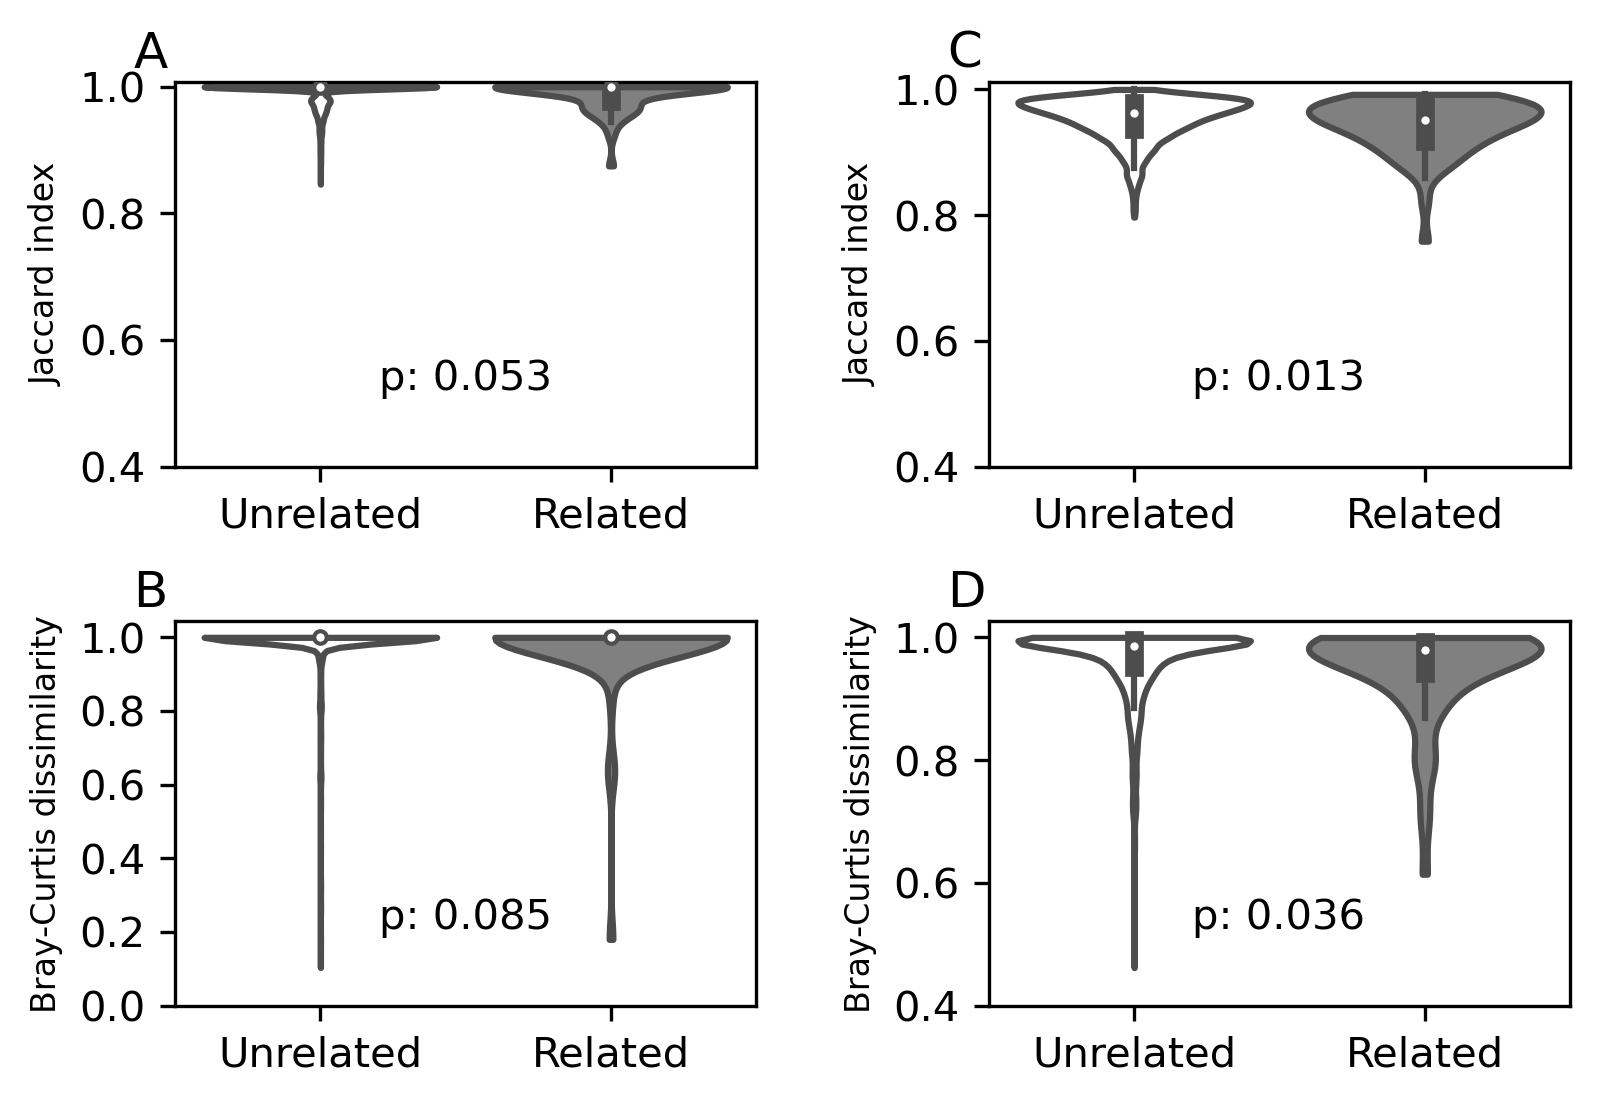

In [140]:
fig_s2 = plt.figure(figsize=(6,4), dpi=300)
gs_fig_s2 = gridspec.GridSpec(2, 2, figure=fig_s2, wspace=0.4, hspace=0.4)

jaccard_vag_ax = fig_s2.add_subplot(gs_fig_s2[0, 0])
bc_vag_ax = fig_s2.add_subplot(gs_fig_s2[1, 0])
jaccard_fecal_ax = fig_s2.add_subplot(gs_fig_s2[0, 1])
bc_fecal_ax = fig_s2.add_subplot(gs_fig_s2[1, 1])

jaccard_vag_vis = sn.violinplot(ax=jaccard_vag_ax,
                                data=distances_comp_vaginal_cxsection,
                                x='same-family', y='jaccard',
                                cut=0, inner='box', dodge=False, width=0.8,
                                hue='same-family', palette=['white','gray'], hue_order=[False, True]
                               )
jaccard_vag_vis.set(xlabel=None)
jaccard_vag_vis.text(0.35,0.2,f'p: {pt_p_vag_jaccard_cxsection:.3f}',
                     transform=jaccard_vag_ax.transAxes)
jaccard_vag_vis.set_yticks(np.arange(0.4,1.2,0.2))
jaccard_vag_vis.set_xticks(np.arange(0,2,1), labels=['Unrelated', 'Related'])
jaccard_vag_vis.get_legend().remove()
jaccard_vag_vis.set_ylabel('Jaccard index', fontsize=8)
jaccard_vag_vis.text(0,1,'A',
                     transform=(jaccard_vag_vis.transAxes + ScaledTranslation(-10/72, +1/72, fig_s2.dpi_scale_trans)),
                     fontsize=12, va='bottom')

bc_vag_vis = sn.violinplot(ax=bc_vag_ax,
                           data=distances_comp_vaginal_cxsection,
                           x='same-family', y='braycurtis',
                           cut=0, inner='box', dodge=False, width=0.8,
                           hue='same-family', palette=['white','gray'], hue_order=[False, True]
                          )
bc_vag_vis.set(xlabel=None)
bc_vag_vis.text(0.35,0.2,f'p: {pt_p_vag_bc_cxsection:.3f}',
                transform=bc_vag_vis.transAxes)
bc_vag_vis.set_yticks(np.arange(0,1.2,0.2))
bc_vag_vis.set_xticks(np.arange(0,2,1), labels=['Unrelated', 'Related'])
bc_vag_vis.get_legend().remove()
bc_vag_vis.set_ylabel('Bray-Curtis dissimilarity', fontsize=8)
bc_vag_vis.text(0,1,'B',
                transform=(bc_vag_vis.transAxes + ScaledTranslation(-10/72, +1/72, fig_s2.dpi_scale_trans)),
                fontsize=12, va='bottom')

jaccard_fecal_vis = sn.violinplot(ax=jaccard_fecal_ax,
                                  data=distances_comp_fecal_cxsection,
                                  x='same-family', y='jaccard',
                                  cut=0, inner='box', dodge=False, width=0.8,
                                  hue='same-family', palette=['white','gray'], hue_order=[False, True]
                                 )
jaccard_fecal_vis.text(0.35,0.2,f'p: {pt_p_fec_jaccard_cxsection:.3f}',
                       transform=jaccard_fecal_vis.transAxes)
jaccard_fecal_vis.set(ylabel=None, xlabel=None)
jaccard_fecal_vis.set_yticks(np.arange(0.4,1.2,0.2))
jaccard_fecal_vis.set_xticks(np.arange(0,2,1), labels=['Unrelated', 'Related'])
jaccard_fecal_vis.get_legend().remove()
jaccard_fecal_vis.set_ylabel('Jaccard index', fontsize=8)
jaccard_fecal_vis.text(0,1,'C',
                       transform=(jaccard_fecal_vis.transAxes + ScaledTranslation(-10/72, +1/72, fig_s2.dpi_scale_trans)),
                       fontsize=12, va='bottom')

bc_fecal_vis = sn.violinplot(ax=bc_fecal_ax,
                             data=distances_comp_fecal_cxsection,
                             x='same-family', y='braycurtis',
                             cut=0, inner='box', dodge=False, width=0.8,
                             hue='same-family', palette=['white','gray'], hue_order=[False, True]
                            )
bc_fecal_vis.set(ylabel=None, xlabel=None)
bc_fecal_vis.text(0.35,0.2,f'p: {pt_p_fec_bc_cxsection:.3f}',
                  transform=bc_fecal_vis.transAxes)
bc_fecal_vis.set_yticks(np.arange(0.4,1.2,0.2))
bc_fecal_vis.set_xticks(np.arange(0,2,1), labels=['Unrelated', 'Related'])
bc_fecal_vis.get_legend().remove()
bc_fecal_vis.set_ylabel('Bray-Curtis dissimilarity', fontsize=8)
bc_fecal_vis.text(0,1,'D',
                  transform=(bc_fecal_vis.transAxes + ScaledTranslation(-10/72, +1/72, fig_s2.dpi_scale_trans)),
                  fontsize=12, va='bottom')



fig_s2.show()
fig_s2.savefig(f'{final_fig_dir}/suppfig2.png', dpi=300, bbox_inches='tight')
fig_s2.savefig(f'{final_fig_dir}/suppfig2.pdf', dpi=300, bbox_inches='tight')

#### 3.6.2: Longitudinal distance comparison between maternal and infant microbiome

In [141]:
## subset distance data for all longitudinal samples

mapping_tab_all_long = pd.concat([mapping_tab_long_maternal,
                                     mapping_tab_agegp1_kid,
                                     mapping_tab_agegp2_kid,
                                     mapping_tab_agegp3_kid])

long_analysis_kid = included_manifest_kid.loc[included_manifest_kid.index.map(lambda x: x in mapping_tab_all_long.index)] 

distances_pairwise_long = \
    distances_pairwise[
        distances_pairwise.index.map(lambda x: x[0] in (mapping_tab_all_long.index) and
                                               x[1] in (mapping_tab_all_long.index)
                                    )
    ].copy()

distances_meta_long = distances_pairwise_long.index.to_frame().reset_index(drop=True).join(
    mapping_tab_all_long.add_suffix('1'), on='sample-id-1').join(
    mapping_tab_all_long.add_suffix('2'), on='sample-id-2'
)
distances_meta_long.set_index(['sample-id-1', 'sample-id-2'], inplace=True)

### generate an indicator for same family 
distances_pairwise_long['same-family'] = distances_meta_long['PregID1'] == distances_meta_long['PregID2']

In [142]:
## pairwise distance long: mom vaginal vs kid fecal
distances_comp_vaginal_long = \
    distances_pairwise_long[(distances_meta_long['mwgs_spec_type1'].astype(int) +
                             distances_meta_long['mwgs_spec_type2'].astype(int) == 8) &
                            (distances_meta_long['mwgs_part_type1'].astype(int) +
                             distances_meta_long['mwgs_part_type2'].astype(int) == 3) &
                            (distances_pairwise_long['same-family'])].copy()

distances_comp_vaginal_long['PregID'] = \
    distances_comp_vaginal_long.index.map(
        lambda x: mapping_tab_all_long.loc[x[0]]['PregID']
    )

distances_comp_vaginal_long['mwgs_age_gp'] = \
    distances_comp_vaginal_long.index.map(
        lambda x: long_analysis_kid.loc[x[0]]['mwgs_age_month_g'] if x[0] in long_analysis_kid.index
                  else long_analysis_kid.loc[x[1]]['mwgs_age_month_g']
    )

In [143]:
## fit mixed effect models (jaccard with age group)
long_jaccard_vaginal_agegp = smf.mixedlm("jaccard ~ mwgs_age_gp",
                                         distances_comp_vaginal_long,
                                         groups=distances_comp_vaginal_long['PregID']).fit(reml=True)

## get the summary and print
long_jaccard_vaginal_agegp_summary = pd.DataFrame({
    'Coef.': long_jaccard_vaginal_agegp.params,
    'Std.Err.': long_jaccard_vaginal_agegp.bse,
    'z': long_jaccard_vaginal_agegp.tvalues,
    'P>|z|': long_jaccard_vaginal_agegp.pvalues,
    '[0.025': long_jaccard_vaginal_agegp.conf_int()[0],
    '0.975]': long_jaccard_vaginal_agegp.conf_int()[1]
})

print(long_jaccard_vaginal_agegp_summary.to_string(float_format="%.4f"))

                     Coef.  Std.Err.        z  P>|z|  [0.025  0.975]
Intercept           0.9861    0.0046 216.5314 0.0000  0.9771  0.9950
mwgs_age_gp[T.2-4] -0.0017    0.0046  -0.3752 0.7075 -0.0107  0.0072
mwgs_age_gp[T.5-7]  0.0032    0.0046   0.7046 0.4810 -0.0057  0.0122
Group Var           0.9836    0.4473   2.1988 0.0279  0.1068  1.8604


/opt/conda/envs/qiime2-2023.7/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [144]:
## fit mixed effect models long (bray-curtis with age group)
long_braycurtis_vaginal_agegp = smf.mixedlm("braycurtis ~ mwgs_age_gp",
                                         distances_comp_vaginal_long,
                                         groups=distances_comp_vaginal_long['PregID']).fit(reml=True)

## get the summary and print
long_braycurtis_vaginal_agegp_summary = pd.DataFrame({
    'Coef.': long_braycurtis_vaginal_agegp.params,
    'Std.Err.': long_braycurtis_vaginal_agegp.bse,
    'z': long_braycurtis_vaginal_agegp.tvalues,
    'P>|z|': long_braycurtis_vaginal_agegp.pvalues,
    '[0.025': long_braycurtis_vaginal_agegp.conf_int()[0],
    '0.975]': long_braycurtis_vaginal_agegp.conf_int()[1]
})

print(long_braycurtis_vaginal_agegp_summary.to_string(float_format="%.4f"))

                     Coef.  Std.Err.       z  P>|z|  [0.025  0.975]
Intercept           0.9722    0.0260 37.3909 0.0000  0.9213  1.0232
mwgs_age_gp[T.2-4] -0.0087    0.0109 -0.8055 0.4205 -0.0300  0.0125
mwgs_age_gp[T.5-7]  0.0006    0.0109  0.0575 0.9542 -0.0206  0.0219
Group Var          10.4843    3.6746  2.8532 0.0043  3.2823 17.6863


In [145]:
## pairwise distance: mom fecal vs kid fecal
distances_comp_fecal_long = \
    distances_pairwise_long[(distances_meta_long['mwgs_spec_type1'].astype(int) +
                             distances_meta_long['mwgs_spec_type2'].astype(int) == 2) &
                            (distances_meta_long['mwgs_part_type1'].astype(int) +
                             distances_meta_long['mwgs_part_type2'].astype(int) == 3) &
                            (distances_pairwise_long['same-family'])].copy()

distances_comp_fecal_long['PregID'] = \
    distances_comp_fecal_long.index.map(
        lambda x: mapping_tab_all_long.loc[x[0]]['PregID']
    )

distances_comp_fecal_long['mwgs_age_gp'] = \
    distances_comp_fecal_long.index.map(
        lambda x: long_analysis_kid.loc[x[0]]['mwgs_age_month_g'] if x[0] in long_analysis_kid.index
                  else long_analysis_kid.loc[x[1]]['mwgs_age_month_g']
    )

In [146]:
## fit mixed effect models (jaccard with age group)
long_jaccard_fecal_agegp = smf.mixedlm("jaccard ~ mwgs_age_gp",
                                         distances_comp_fecal_long,
                                         groups=distances_comp_fecal_long['PregID']).fit(reml=True)

## get the summary and print
long_jaccard_fecal_agegp_summary = pd.DataFrame({
    'Coef.': long_jaccard_fecal_agegp.params,
    'Std.Err.': long_jaccard_fecal_agegp.bse,
    'z': long_jaccard_fecal_agegp.tvalues,
    'P>|z|': long_jaccard_fecal_agegp.pvalues,
    '[0.025': long_jaccard_fecal_agegp.conf_int()[0],
    '0.975]': long_jaccard_fecal_agegp.conf_int()[1]
})

print(long_jaccard_fecal_agegp_summary.to_string(float_format="%.4f"))

                     Coef.  Std.Err.        z  P>|z|  [0.025  0.975]
Intercept           0.9619    0.0061 158.9396 0.0000  0.9501  0.9738
mwgs_age_gp[T.2-4] -0.0157    0.0045  -3.4789 0.0005 -0.0245 -0.0069
mwgs_age_gp[T.5-7] -0.0249    0.0045  -5.5190 0.0000 -0.0337 -0.0161
Group Var           2.5991    0.9961   2.6093 0.0091  0.6468  4.5513


/opt/conda/envs/qiime2-2023.7/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [147]:
## fit mixed effect models (bray-curtis with age group)
long_braycurtis_fecal_agegp = smf.mixedlm("braycurtis ~ mwgs_age_gp",
                                         distances_comp_fecal_long,
                                         groups=distances_comp_fecal_long['PregID']).fit(reml=True)

## get the summary and print
long_braycurtis_fecal_agegp_summary = pd.DataFrame({
    'Coef.': long_braycurtis_fecal_agegp.params,
    'Std.Err.': long_braycurtis_fecal_agegp.bse,
    'z': long_braycurtis_fecal_agegp.tvalues,
    'P>|z|': long_braycurtis_fecal_agegp.pvalues,
    '[0.025': long_braycurtis_fecal_agegp.conf_int()[0],
    '0.975]': long_braycurtis_fecal_agegp.conf_int()[1]
})

print(long_braycurtis_fecal_agegp_summary.to_string(float_format="%.4f"))

                     Coef.  Std.Err.       z  P>|z|  [0.025  0.975]
Intercept           0.9640    0.0112 86.1073 0.0000  0.9420  0.9859
mwgs_age_gp[T.2-4] -0.0002    0.0109 -0.0189 0.9849 -0.0216  0.0212
mwgs_age_gp[T.5-7] -0.0054    0.0109 -0.4940 0.6213 -0.0268  0.0160
Group Var           1.1058    0.4888  2.2620 0.0237  0.1477  2.0638


/opt/conda/envs/qiime2-2023.7/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
